# Blum et al. 2020 Analysis Notebook

In [1]:
# Plot PNGs inline:
options(jupyter.plot_mimetypes = 'image/png')

# Load in custom seurat wrapper functions:
source('/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/seurat_analysis_scripts/sc_functions.R')

# Libraries used in analysis pipeline:
library(Seurat)
library(ggplot2)
library(sets)
library(ComplexHeatmap)
library(gplots)
library(ggpubr)

# experiment names for each control sample:
ctl.ids <- c("SI-GA-H8", "singleCellPilot/ctl_MNs_old_newREF", "singleCell2ndExp_531/5_31_MN_sample1", "singleCell2ndExp_531/5_31_MN_sample2", "ctl_MNs_SCRNA_6_25_all", "3nextseqs_11_18/3nextseq_run_11_5_endpoint_mixed")

# Intermediate save directory for .RDS files:
load.dir <- '/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/analysis/12_29/motor_neurons/'

# Save directory for plot output:
save.dir <- '/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/analysis/2_27/'
dir.create(file.path(save.dir))

graph.dir <- paste(save.dir, '/graphs/', sep ='')
dir.create(file.path(graph.dir))

# enable high maximum RAM
options(future.globals.maxSize= 4194304000)



Registered S3 method overwritten by 'sets':
  method        from   
  print.element ggplot2

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘ggpubr’


The following object is masked from ‘package:sets’:

    %>%


Warning message in dir.create(file.path(save.dir)):
“'/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/analysis/2_27' already exists”
Warning message in dir.create(file.path(graph.dir)):
“'/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/analysis/2_27//graphs' already exi

### Load, read-depth normalize, and integrate each experiment to remove batch-effects

In [2]:
# Load each 10X raw counts matrix (.h5) separately, then combine into one seurat object
# Mitochondrial reads removed prior to any downstream processing. 
all.exps.ctl <- load.and.aggregate(dataset_loc,ids, 'all.exps.ctl')
# Normalize each experiment based on total number of reads
all.exps.ctl <- normalize.aggregated.object(all.exps.ctl)
# Run Seurat Integrate across replicates to normalize out any spurrious batch effects.
all.exps.ctl <- integrate.exp.list(all.exps.ctl, features.to.keep=rownames(all.exps,ctl[[1]]),future.workers=10)

# Save RDS file with the list of integrated objects (each replicate separated) 
saveRDS(object=all.exps.ctl, file='all.exps.integrated.RDS')

### Commented out, but this is how to read in saved RDS file (RAM intensive process, best to only do once then save though saving is time-intensive)
all.exps.ctl <- readRDS(paste(load.dir, 'all.exps.integrated.RDS'))


Warning message in gzfile(file, "rb"):
“cannot open compressed file '/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/analysis/12_29/motor_neurons/ all.exps.integrated.RDS', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


### Assign cell labels and remove doublet clusters

In [3]:
excite.neuron.clusters <- c(19,18,31,1,20,37,33,38,0,5)
inhib.neuron.clusters <- c(7,14,32,27,15,24)
cholin.neuron.clusters <- c(25,13,28,29,11,23,17,4,8,34,21,30,36)
cholin.neuron.sod.clusters <- c(25,13,28,29,11,23,17,4,8,34,21,30,36,6)
olig.clusters <- c(9,2,35)
endo.clusters <- c(16,22)
astro.clusters <- c(3)
microglia.clusters <- c(10)
Doublet.clusters <-c(6,12, 26)


new.cell.labels <- c('Excitatory neurons', 'Inhibitory neurons', 'Cholinergic neurons', 'Oligodendrocytes', 'Endothelial cells', 'Astrocytes', 'Microglia/Macrophages','Doublet')

cluster.list <- list(excite.neuron.clusters, inhib.neuron.clusters, cholin.neuron.clusters, olig.clusters, endo.clusters,astro.clusters, microglia.clusters,Doublet.clusters)
cluster.vec <- c(cholin.neuron.clusters,excite.neuron.clusters, inhib.neuron.clusters, olig.clusters,astro.clusters, microglia.clusters, endo.clusters)


In [5]:
Idents(all.exps.ctl) <- all.exps.ctl$seurat_clusters
all.exps.ctl <- reset.ids(all.exps.ctl,ident1.list=cluster.list, ident2.label='cell_type', new.cell.labels)
Idents(all.exps.ctl) <- all.exps.ctl$cell_type


ERROR: Error in eval(expr, envir, enclos): object 'all.exps.ctl' not found


In [4]:
Idents(all.exps.ctl) <- all.exps.ctl$cell_type
all.exps.ctl.nodub <- subset(all.exps.ctl, idents=c('Excitatory neurons', 'Inhibitory neurons', 'Cholinergic neurons', 'Oligodendrocytes', 'Endothelial cells', 'Astrocytes', 'Microglia/Macrophages'))

### Generate cluster marker table (Supp. Table S1a)

In [9]:
DefaultAssay(all.exps.ctl.nodub) <- 'RNA'
Idents(all.exps.ctl.nodub) <- all.exps.ctl.nodub$seurat_clusters
all.celltype.markers <- FindAllMarkers(all.exps.ctl.nodub, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34

Calculating cluster 35

Calculating cluster 36

Calculating cluster 37

Calculating cluster 38



In [10]:
write.csv(file=paste(graph.dir,'all.celltype.markers'), all.celltype.markers)

### Subset cholinergic clusters, find new PCs and recluster

In [54]:
DefaultAssay(all.exps.list$ctl) <- 'integrated'
Idents(all.exps.list$ctl) <- all.exps.list$ctl$seurat_clusters
first.cholin <- subset(all.exps.list$ctl, idents=cholin.neuron.clusters)
first.cholin <- find.pcs.and.clustids(first.cholin)


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Centering and scaling data matrix

PC_ 1 
Positive:  Prkg1, Pbx3, Dgkb, Ncam1, Gap43, Celf4, Alk, Grm5, Gm29683, Nav2 
	   March1, Fnbp1l, Klhl1, Simc1, Plxdc2, Ddx5, Kif26b, 9530026P05Rik, Agpat4, Apba1 
	   CT025619.1, Nr2f2, Psd, Zfp804b, Ncam2, Plcl1, Fgf14, Hap1, Dab1, Nox4 
Negative:  Gria3, Caln1, Pex5l, Zfp385b, Bcl6, Sgcz, Zfpm2, Aifm3, Nos1ap, Gm12239 
	   Rgs7bp, Itpr1, Sgcd, Adcy8, Fstl4, Gfra1, Tbc1d4, Itga6, Aff1, Cdh20 
	   Plekhd1, Lrrc4c, Tapt1, Mpp7, Ssbp2, Lyst, Sh3pxd2a, Svil, L3mbtl4, Prune2 
PC_ 2 
Positive:  Slit3, Ppp2r2b, Nrg1, Galnt13, Fam155a, Miat, Igsf9b, Prune2, Nkain2, Clstn2 
	   Dab1, Syt2, Ntng1, Slc4a4, Nefm, Ptprg, Ctnna2, Msi2, Gng12, March1 
	   Sdk2, Farp1, Fut9, Grid2, Eda, Vav3, Col5a3, Ank2, Grin2b, Hmcn1 
Negative:  Pax2, Arhgap6, Gpc5, Mpped2, Kctd16, Zfhx4, Auts2, Xylt1, Chrm3, Lhfpl3 
	   Unc13c, Ptprm, Fstl5, Lrrc4c, Erbb4, Dmd, Pcsk

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13589
Number of edges: 855092

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9574
Number of communities: 21
Elapsed time: 2 seconds


In [6]:
first.cholin <- RunUMAP(first.cholin, dims=c(1:10), seed.use=5, n.neighbors = 40L)

ERROR: Error in RunUMAP(first.cholin, dims = c(1:10), seed.use = 5, n.neighbors = 40L): object 'first.cholin' not found


### Assign cholinergic cell labels based on new clustering

In [56]:
cholin.cell.labels <- c('Alpha MNs', 'Gamma MNs', 'Cholinergic partition cells', 'Cholinergic inhibitory INs', 'Postn+ sympathetic MNs', 'Smoc2+ sympathetic MNs', 'Rxfp1+ parasympathetic MNs', 'Cdh6+ preganglionic MNs')
cholin.cell.classes <- c('Visceral MNs', 'Skeletal MNs', 'Cholinergic INs')

alpha.clusters <- c(0)
gamma.clusters <- c(13,5)
premotor.chol.clusters <- c(3)
premotor.inhib.clusters <- c(10,18,20)
postn.pregang <- c(1,15)
smoc2.pregang <- c(2,16,19)
cdh6.pregang <- c(4,7,8,9,11,14,17)
rxfp1.pregang <- c(6,12)

visceral.clusters <- c(postn.pregang,smoc2.pregang,cdh6.pregang,rxfp1.pregang)
skeletal.clusters <- c(alpha.clusters, gamma.clusters)
interneuron.clusters <- c(premotor.chol.clusters, premotor.inhib.clusters)

class.list <- list(visceral.clusters, skeletal.clusters, interneuron.clusters)
cluster.list <- list(alpha.clusters, gamma.clusters, premotor.chol.clusters, premotor.inhib.clusters,postn.pregang, smoc2.pregang, rxfp1.pregang, cdh6.pregang)


In [57]:
Idents(first.cholin) <- first.cholin$seurat_clusters
# setting IDs to refined cell types
# first.cholin <- reset.ids(first.cholin,ident1.list=cluster.list, ident2.label='cell_type', cholin.cell.labels)
# setting IDs to motor neuron classes
first.cholin <- reset.ids(first.cholin,ident1.list=class.list, ident2.label='cell_class', cholin.cell.classes)

Idents(first.cholin) <- first.cholin$cell_type

In [2]:
# saveRDS(object=first.cholin, file=paste(load.dir, 'first.cholin.2.29.RDS'))
first.cholin <- readRDS(file = paste(load.dir, 'first.cholin.2.29.RDS'))

In [12]:
DefaultAssay(first.skeletal) <- 'RNA'
FeaturePlot(first.skeletal, features = c('Chodl', 'Mnx1'))

ERROR: Error in DefaultAssay(first.skeletal) <- "RNA": object 'first.skeletal' not found


In [13]:
# Umap  blowouts  for preganglionic, skeletal, and interneurons
DefaultAssay(first.cholin) <- 'integrated'
Idents(first.cholin) <- first.cholin$seurat_clusters
first.inter <- find.pcs.and.clustids(subset(first.cholin, idents=interneuron.clusters))
first.visceral <- find.pcs.and.clustids(subset(first.cholin, idents=visceral.clusters))
first.skeletal <- find.pcs.and.clustids(subset(first.cholin, idents = skeletal.clusters))



Centering and scaling data matrix

PC_ 1 
Positive:  Nxph1, Kcnip4, Grm7, Cdh4, Grin2b, Apba1, Ralyl, Gpc5, Asic2, Celf2 
	   Nrxn1, Kcnd2, Mdga2, C130071C03Rik, Nrp1, Rarb, Igsf3, Nrg3, Camk2a, Il1rapl1 
	   Kctd16, Arnt2, Cacna2d2, Cttnbp2, Nlgn1, Plxdc2, Focad, Slco3a1, Rasgrf2, Cntn3 
Negative:  Ldb2, Slit3, Sgcd, Gabrb1, Auts2, Cdh18, Cdh6, Ptprm, Inpp4b, Erbb4 
	   Vwc2, Fam155a, Cadps, Sema5a, Pcdh9, Ppm1h, Zfhx4, Dnm3, Dlgap2, Lrrc4c 
	   Epha5, Nhsl1, Hs6st3, Maml2, Ror1, Pde4b, Zfp804b, Gpc6, Gria3, Large1 
PC_ 2 
Positive:  Nrg1, Unc13c, Rgs6, Ntrk3, Pbx3, Adgrb3, Prkg1, Hs6st3, Maml2, Prr16 
	   Grm5, Lhfpl3, Pde4b, Kcnma1, Cdh6, Sema3a, Kalrn, Flrt2, Ephb1, Cttnbp2 
	   Enox1, Frmpd3, Gm28928, Rarb, Vsnl1, Opcml, Igsf3, Kirrel3, Mdga2, Ank3 
Negative:  Sdk1, Clstn2, Zfp536, Il1rapl2, Sdk2, Fstl1, Slc4a4, Lrrc7, Trpm3, Gfra1 
	   Dgkg, Pde1a, Frmd5, Nkain3, Pld5, Gria4, Gpc5, Mctp1, Gpc6, Chd7 
	   Camk4, Fam19a1, Fut9, Ctnna2, Stk32a, Cntn5, Pcdh7, Pex5l, C530008M17Rik, Pt

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1789
Number of edges: 89011

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8713
Number of communities: 8
Elapsed time: 0 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Lrrc4c, Arhgap6, Gpc5, Zfhx4, Pcsk5, Dock10, Chrm3, Usp3, Grid1, Bcl6 
	   Ptprm, Peli2, Epha5, Anks1b, Creb5, Rasgrf1, Bbx, Mtus2, Erbb4, Gm28928 
	   Xylt1, Plce1, Auts2, Adgrb3, Camk2d, Itpr1, Trpm3, Gria3, Park2, Stxbp6 
Negative:  Slit3, Ppp2r2b, Nrg1, Ncam2, Msi2, Grm5, Ralyl, Kcnip4, Lrrtm4, March1 
	   Aff3, Clstn2, Plcl1, Fgf14, Galnt13, Igsf9b, Rbms3, Dlgap2, Gm45321, Cadps 
	   Nav2, Syndig1, Grin2b, Kif26b, Slc4a4, Syt2, Grid2, Gas7, Eda, Vav3 
PC_ 2 
Positive:  Cadm1, Cdh6, Ptprz1, Prkg1, Enox1, Nrxn1, Cntnap4, Grm5, Nrg3, Lrrc7 
	   Aff3, Plxdc2, Ctnna3, Nkain2, Gria4, Syndig1, Hip1, Fgd5, Gfra1, Ank3 
	   Gas7, Rgs6, St6galnac5, Cntn5, Gpc5, Gpi1, Nebl, Rbfox3, Rbms3, Foxp1 
Negative:  Gabrg3, Hpgds, Pard3b, Inpp4b, Creb5, Adgrb3, Opcml, Dgkb, Pde1a, Adgrl2 
	   Cdh11, Vgll4, Pitpnc1, Nfib, Tnr, Cacnb2, Htr2a, Cntn6, Gabrb1, Hs6st3 
	   Vsnl1, Slit3, Pam, Ralyl, Cntn4, Klhl1, Prr16, Afap1, Svil, Gm28905 
PC_ 3 
Positiv

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8495
Number of edges: 484879

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9424
Number of communities: 16
Elapsed time: 1 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Kirrel3, Plekhg1, Pard3b, Klhl1, Kcnd2, Zfp536, Opcml, Creb5, Gabrg3, Kif26b 
	   Arnt2, Mast4, Dlgap1, Asic2, Pam, Dock10, Ank3, Hmcn1, Htr1f, Dab1 
	   Cdh11, Htr2a, Cntnap5b, Mthfd1l, Ppargc1a, Hunk, Vwc2, Polb, Plcl2, Cblb 
Negative:  Sv2b, Stk32a, Cntn5, Tapt1, 9530059O14Rik, Kctd16, Pex5l, Sgcz, Dlgap2, Itpr1 
	   Slit3, Cadm1, Pld5, Nrp1, Sema3a, Gm28928, Plce1, Nos1ap, Ntng1, Rapgef4 
	   Col5a3, Nkain2, Rbfox3, Cdh18, Ppp2r2b, Gng12, Clstn2, Focad, Dixdc1, Dgkg 
PC_ 2 
Positive:  Sgcd, Stxbp6, Ssbp2, Man1a, Adcy8, Cdh20, Plcl1, Dmd, Svil, Zmat4 
	   Anks1b, Pcp4l1, Nlk, Auts2, Nos1ap, Elovl5, Ctnna2, Clvs1, Lyst, Gpc5 
	   Sgcz, Vav3, Pde1a, Fam155a, Sipa1l3, Usp53, Ptprg, 6430573F11Rik, Fstl4, Ncoa1 
Negative:  Pde4b, Dlg2, Pitpnc1, Pde4d, Prkg1, Lrrtm4, Cntnap4, Tshz2, Csmd2, Pcdh7 
	   Prr16, Mctp1, Klhl1, Pard3b, Frmd4b, Cers6, Plxdc2, Rgs6, Cdh6, Creb5 
	   St6galnac5, Nav2, Cdh11, Kif26b, Nkain3, Ppp2r2b, Ptprj, Slc4a4

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3305
Number of edges: 185628

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8819
Number of communities: 11
Elapsed time: 0 seconds


In [14]:
first.inter <- RunUMAP(first.inter, dims=c(1:10), seed.use=5, n.neighbors = 40L)
first.visceral <- RunUMAP(first.visceral, dims=c(1:10), seed.use=5, n.neighbors = 40L)
first.skeletal <- RunUMAP(first.skeletal, dims=c(1:10), seed.use=5, n.neighbors = 40L)

14:55:02 UMAP embedding parameters a = 0.9922 b = 1.112

14:55:02 Read 1789 rows and found 10 numeric columns

14:55:02 Using Annoy for neighbor search, n_neighbors = 40

14:55:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

14:55:02 Writing NN index file to temp file /tmp/Rtmp6tkbd2/filebdf741e3d596

14:55:02 Searching Annoy index using 8 threads, search_k = 4000

14:55:03 Annoy recall = 100%

14:55:03 Commencing smooth kNN distance calibration using 8 threads

14:55:04 Initializing from normalized Laplacian + noise

14:55:04 Commencing optimization for 500 epochs, with 94294 positive edges

14:55:10 Optimization finished

14:55:10 UMAP embedding parameters a = 0.9922 b = 1.112

14:55:10 Read 8495 rows and found 10 numeric columns

14:55:10 Using Annoy for neighbo

In [3]:
# saveRDS(object=first.inter, file=paste(load.dir, 'first.inter.2.29.RDS'))
# saveRDS(object=first.visceral, file=paste(load.dir, 'first.visceral.2.29.RDS'))
# saveRDS(object=first.skeletal, file=paste(load.dir, 'first.skeletal.2.29.RDS'))
first.inter <- readRDS(file = paste(load.dir,'first.inter.2.29.RDS' ))
first.visceral <- readRDS(file = paste(load.dir,'first.visceral.2.29.RDS' ))
first.skeletal <- readRDS(file = paste(load.dir,'first.skeletal.2.29.RDS' ))

In [4]:
DefaultAssay(first.skeletal) <- 'RNA'
Idents(first.skeletal) <- first.skeletal$seurat_clusters
skeletal.celltype.markers <- FindAllMarkers(first.skeletal, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)



Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



In [ ]:
write.csv(file=paste(graph.dir,'skeletal.celltype.markers.csv'), skeletal.celltype.markers)

In [5]:
first.alpha.integrated <- RunUMAP(first.alpha.integrated, dims=c(1:10), seed.use=4, n.neighbors = 40L, spread = 1.5)

ERROR: Error in RunUMAP(first.alpha.integrated, dims = c(1:10), seed.use = 4, : object 'first.alpha.integrated' not found


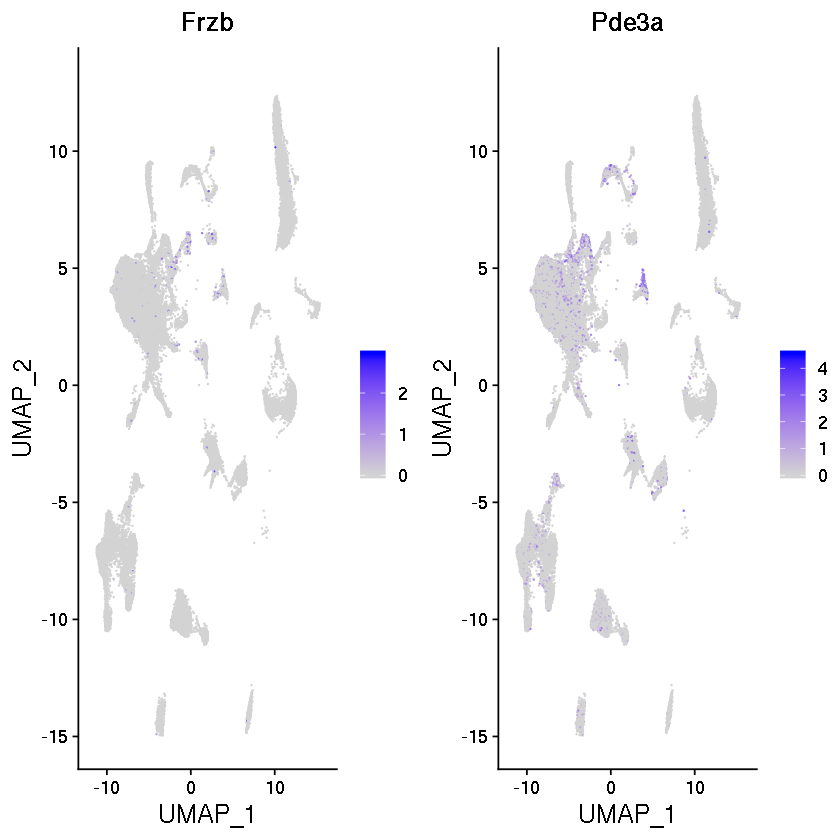

In [140]:
FeaturePlot(all.exps.ctl.nodub, features = c('Frzb', 'Pde3a'))

# Supplemental Figures

## Supplemental Tables

In [152]:
write.csv(file=paste(graph.dir,'alpha.celltype.markers.csv'), alpha.integrated.celltype.markers)

## S2e-f --> UMAP of Fbn2 and Zeb2 across all cholinergic cells 

In [7]:
DefaultAssay(first.inter) <- 'RNA'
fig_s4i <- FeaturePlot(first.inter, label=T, label.size=5.5, features = c('Nrxn3')) + NoAxes() 

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


In [8]:
ggsave(filename = paste(graph.dir,'fig_s4i.pdf'), plot= fig_s4i, device = 'pdf')


Saving 6.67 x 6.67 in image



In [159]:
DefaultAssay(first.cholin) <- 'RNA'
fig_s2e <- FeaturePlot(first.cholin, label=T, label.size=5.5, features = c('Fbn2')) + NoAxes() +
theme(title=element_text(size=20))
fig_s2f <- FeaturePlot(first.cholin, label=T, label.size=5.5, features = c('Zeb2')) + NoAxes() +
theme(title=element_text(size=20))

In [162]:
ggsave(filename = paste(graph.dir,'fig_s2e.pdf'), plot= fig_s2e, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s2f.pdf'), plot= fig_s2f, device = 'pdf')

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Fig S1a-d

In [18]:
DefaultAssay(all.exps.ctl.nodub) <- 'RNA'
Idents(all.exps.ctl.nodub) <- all.exps.ctl.nodub$seurat_clusters
fig_s1a <- DimPlot(all.exps.ctl.nodub, label=T, label.size=5.5) + NoLegend() + NoAxes()
fig_s1a_wlegend <-DimPlot(all.exps.ctl.nodub, label=T, label.size=5.5) + NoAxes()

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


In [20]:
ggsave(filename = paste(graph.dir,'fig_s1a.pdf'), plot= fig_s1a, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s1a_wlegend.pdf'), plot= fig_s1a_wlegend, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [9]:
glut_markers <- c('Slc17a8', 'Slc17a6')
gaba_markers <- c('Gad1', 'Gad2')
glyc_markers <- c('Slc6a5')
astro_markers <- c('Gfap', 'Aqp4')
microglia_markers <- c('Cx3cr1', 'Trem2', 'P2ry12')
endo_markers <- c('Cldn5')
oligo_markers <- c('Mbp', 'Mobp')
cholin_markers <- c('Slc5a7', 'Chat')
all.markers <- c(cholin_markers, glut_markers, gaba_markers, glyc_markers, oligo_markers, astro_markers, microglia_markers, endo_markers)


In [10]:
# all.exps.ctl.nodub$cell_type <- Idents(all.exps.ctl.nodub)
Idents(all.exps.ctl.nodub) <- all.exps.ctl.nodub$seurat_clusters
Idents(all.exps.ctl.nodub) <- factor(Idents(all.exps.ctl.nodub), levels=cluster.vec)


In [11]:
all.heatmap.avgexp <- AverageExpression(all.exps.ctl.nodub, features=all.markers, assays = 'RNA')
# process data first: want to just show average expression per cluster for top X genes
all.heatmap.normexp <- all.heatmap.avgexp$RNA/rowMeans(all.heatmap.avgexp$RNA)
# all.exps.heatmap.normexp


Finished averaging RNA for cluster 25

Finished averaging RNA for cluster 13

Finished averaging RNA for cluster 28

Finished averaging RNA for cluster 29

Finished averaging RNA for cluster 11

Finished averaging RNA for cluster 23

Finished averaging RNA for cluster 17

Finished averaging RNA for cluster 4

Finished averaging RNA for cluster 8

Finished averaging RNA for cluster 34

Finished averaging RNA for cluster 21

Finished averaging RNA for cluster 30

Finished averaging RNA for cluster 36

Finished averaging RNA for cluster 19

Finished averaging RNA for cluster 18

Finished averaging RNA for cluster 31

Finished averaging RNA for cluster 1

Finished averaging RNA for cluster 20

Finished averaging RNA for cluster 37

Finished averaging RNA for cluster 33

Finished averaging RNA for cluster 38

Finished averaging RNA for cluster 0

Finished averaging RNA for cluster 5

Finished averaging RNA for cluster 7

Finished averaging RNA for cluster 14

Finished averaging RNA for clus

In [13]:
pdf(file = paste(graph.dir, 'fig_s1b.pdf'), height = 8, width = 12)
heatmap.2(as.matrix(all.heatmap.normexp),
    main = "Test", # heat map title
    notecol="black",      # change font color of cell labels to black
    density.info="none",  # turns off density plot inside color legend
    trace="none",         # turns off trace lines inside the heat map
#     margins =c(1,11),     # widens margins around plot
    dendrogram='both',     # only draw a row dendrogram
    Colv=F,
    Rowv=F,  
    key=T,
    col=colorRampPalette(c("white","red", "dark red", 'dark red'))(n = 40),
    symm=F,
    symbreaks=F,
    cexCol=1.2,
    srtCol=70,
    margins=c(12,12))
dev.off()

Warning message in heatmap.2(as.matrix(all.heatmap.normexp), main = "Test", notecol = "black", :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”
Warning message in heatmap.2(as.matrix(all.heatmap.normexp), main = "Test", notecol = "black", :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”


png 
  2

## S3

In [166]:
DefaultAssay(first.visceral) <- 'RNA'
fig_s3b_1 <- FeaturePlot(first.visceral, label=T, label.size=5.5, features = c('Rxfp1')) + NoAxes() +
theme(title=element_text(size=20))

fig_s3b_2 <- FeaturePlot(first.visceral, label=T, label.size=5.5, features = c('Sst')) + NoAxes() +
theme(title=element_text(size=20))

fig_s3b_3 <- FeaturePlot(first.visceral, label=T, label.size=5.5, features = c('Bdnf')) + NoAxes() +
theme(title=element_text(size=20))

fig_s3b_4 <- FeaturePlot(first.visceral, label=T, label.size=5.5, features = c('Ngf')) + NoAxes() +
theme(title=element_text(size=20))

fig_s3b_5 <- FeaturePlot(first.visceral, label=T, label.size=5.5, features = c('Eln')) + NoAxes() +
theme(title=element_text(size=20))

fig_s3b_6 <- FeaturePlot(first.visceral, label=T, label.size=5.5, features = c('Penk')) + NoAxes() +
theme(title=element_text(size=20))

In [168]:
ggsave(filename = paste(graph.dir,'fig_s3b_1.pdf'), plot= fig_s3b_1, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s3b_2.pdf'), plot= fig_s3b_2, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s3b_3.pdf'), plot= fig_s3b_3, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s3b_4.pdf'), plot= fig_s3b_4, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s3b_5.pdf'), plot= fig_s3b_5, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s3b_6.pdf'), plot= fig_s3b_6, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [172]:
DefaultAssay(all.exps.ctl.nodub) <- 'RNA'
fig_s3f_1 <- FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Gldn')) + NoAxes() +
theme(title=element_text(size=20))

In [173]:
ggsave(filename = paste(graph.dir,'fig_s3f_1.pdf'), plot= fig_s3f_1, device = 'pdf')


Saving 6.67 x 6.67 in image



In [174]:
DefaultAssay(all.exps.ctl.nodub) <- 'RNA'
fig_s4a <- FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Vipr2')) + NoAxes() +
theme(title=element_text(size=20))

In [175]:
ggsave(filename = paste(graph.dir,'fig_s4a.pdf'), plot= fig_s4a, device = 'pdf')


Saving 6.67 x 6.67 in image



## S4

In [45]:
# DefaultAssay(first.skeletal) <- 'RNA'
# fig_s4a_1 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Rora')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_2 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Stxbp6')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_3 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Sgcd')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_4 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Gpr149')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_5 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Plch1')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_6 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Nos1ap')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_7 <- FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Vipr2')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_8 <- FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Npas1')) + NoAxes() +
# theme(title=element_text(size=20))

# fig_s4a_9 <- FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Gldn')) + NoAxes() +
# theme(title=element_text(size=20))

fig_s4a_10 <- FeaturePlot(first.inter, label=T, label.size=5.5, features = c('Pitx2', 'Piezo2'), blend = T ) + NoAxes() +
theme(title=element_text(size=20))

fig_s4a_11 <- FeaturePlot(first.inter, label=T, label.size=5.5, features = c('Piezo2')) + NoAxes() +
theme(title=element_text(size=20))

In [10]:
fig_s4a_7 <- FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Cartpt')) + NoAxes() +
theme(title=element_text(size=20))

In [23]:
DefaultAssay(first.inter) <- 'RNA'

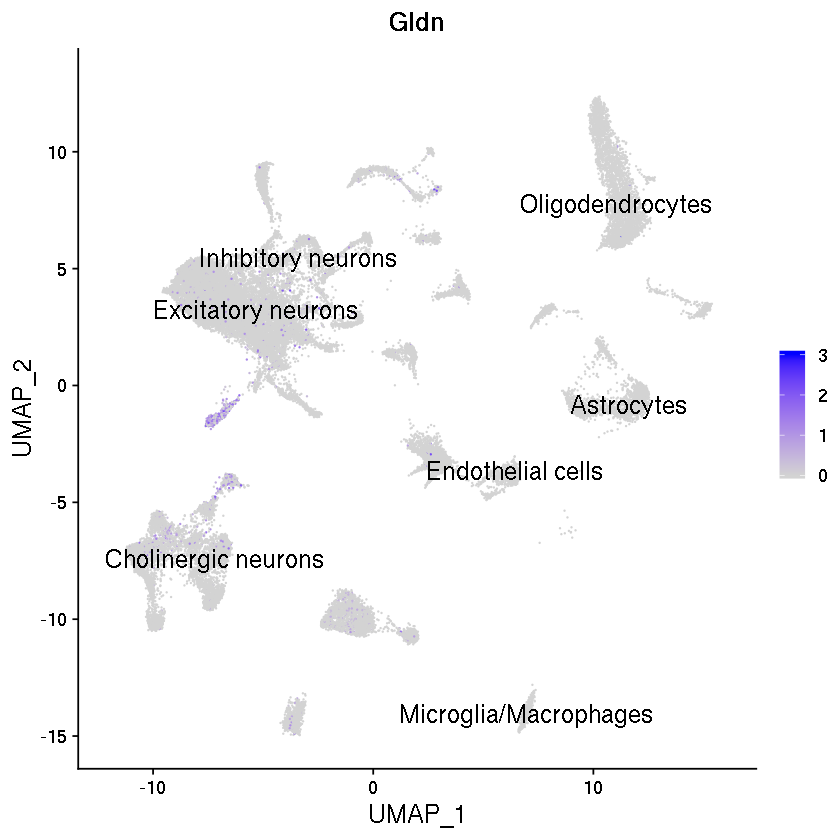

In [14]:
Idents(all.exps.ctl.nodub) <- all.exps.ctl.nodub$cell_type
FeaturePlot(all.exps.ctl.nodub, label=T, label.size=5.5, features = c('Gldn'))


In [9]:
# test <- FindMarkers(all.exps.ctl.nodub, ident.1=c(25), max.cells.per.ident = 100)
# test[order(test$pct.2),]

In [87]:
DefaultAssay(first.skeletal) <- 'RNA'
fig_s4b_1 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Creb5')) + NoAxes() +
theme(title=element_text(size=20))

fig_s4b_2 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Klhl1')) + NoAxes() +
theme(title=element_text(size=20))

fig_s4b_3 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Sema6d')) + NoAxes() +
theme(title=element_text(size=20))

fig_s4b_4 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Pard3b')) + NoAxes() +
theme(title=element_text(size=20))

fig_s4b_5 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Sema3c')) + NoAxes() +
theme(title=element_text(size=20))

fig_s4b_6 <- FeaturePlot(first.skeletal, label=T, label.size=5.5, features = c('Nrp2')) + NoAxes() +
theme(title=element_text(size=20))


In [46]:
# ggsave(filename = paste(graph.dir,'fig_s4a_1.pdf'), plot= fig_s4a_1, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_s4a_2.pdf'), plot= fig_s4a_2, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_s4a_3.pdf'), plot= fig_s4a_3, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_s4a_4.pdf'), plot= fig_s4a_4, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_s4a_5.pdf'), plot= fig_s4a_5, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_s4a_6.pdf'), plot= fig_s4a_6, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4a_7.pdf'), plot= fig_s4a_7, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4a_8.pdf'), plot= fig_s4a_8, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4a_9.pdf'), plot= fig_s4a_9, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4a_10.pdf'), plot= fig_s4a_10, height = 8, width = 24, device = 'pdf')



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [89]:
ggsave(filename = paste(graph.dir,'fig_s4b_1.pdf'), plot= fig_s4b_1, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4b_2.pdf'), plot= fig_s4b_2, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4b_3.pdf'), plot= fig_s4b_3, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4b_4.pdf'), plot= fig_s4b_4, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4b_5.pdf'), plot= fig_s4b_5, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s4b_6.pdf'), plot= fig_s4b_6, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



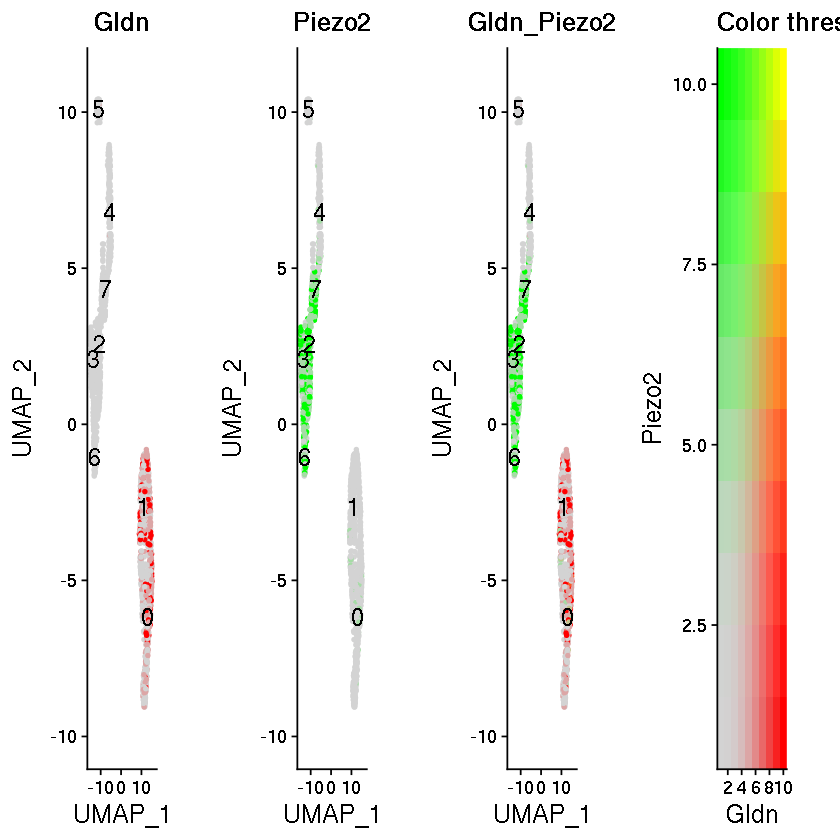

In [44]:
fig_s4a_10

In [98]:
skeletal.cell.labels <- c('Alpha Motor Neurons', 'Gamma Motor Neurons', 'Beta(?) Motor Neurons')


alpha.clusters <- c(1,3,4,5,7,8,9,10)
gamma.clusters <- c(0,6)
beta.clusters <- c(2)


skeletal.list <- list(alpha.clusters, gamma.clusters, beta.clusters)



In [100]:
Idents(first.skeletal) <- first.skeletal$seurat_clusters
first.skeletal <- reset.ids(first.skeletal,ident1.list=skeletal.list, ident2.label='skeletal_subtype', skeletal.cell.labels)
Idents(first.skeletal) <- first.skeletal$skeletal_subtype

In [113]:
fig_s4_c <-DimPlot(first.skeletal) + NoLegend() + NoAxes()
ggsave(filename = paste(graph.dir,'fig_s4_c.pdf'), plot= fig_s4_c, device = 'pdf')


Saving 6.67 x 6.67 in image



## S5

### Piezo2

In [128]:
DefaultAssay(first.alpha) <- 'RNA'
fig_s5a_1 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Piezo2')) + NoAxes() +
theme(title=element_text(size=20))

fig_s5a_2 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Prom1')) + NoAxes() +
theme(title=element_text(size=20))

fig_s5a_3 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Sox6')) + NoAxes() +
theme(title=element_text(size=20))

fig_s5a_4 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Prlr')) + NoAxes() +
theme(title=element_text(size=20))

fig_s5a_5 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Hcrtr2')) + NoAxes() +
theme(title=element_text(size=20))

fig_s5a_6 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Erbb4')) + NoAxes() +
theme(title=element_text(size=20))




In [129]:
ggsave(filename = paste(graph.dir,'fig_s5a_1.pdf'), plot= fig_s5a_1, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s5a_2.pdf'), plot= fig_s5a_2, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s5a_3.pdf'), plot= fig_s5a_3, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s5a_4.pdf'), plot= fig_s5a_4, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s5a_5.pdf'), plot= fig_s5a_5, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s5a_6.pdf'), plot= fig_s5a_6, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [130]:
DefaultAssay(first.alpha) <- 'RNA'
fig_s6a_1 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Chodl')) + NoAxes() +
theme(title=element_text(size=20))

fig_s6a_2 <- FeaturePlot(first.alpha, label=T, label.size=5.5, features = c('Sv2a')) + NoAxes() +
theme(title=element_text(size=20))



In [131]:
ggsave(filename = paste(graph.dir,'fig_s6a_1.pdf'), plot= fig_s6a_1, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_s6a_2.pdf'), plot= fig_s6a_2, device = 'pdf')

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [270]:
hcrtr2.exp <- as.matrix(GetAssayData(first.alpha.integrated, slot='data', assay='RNA'))['Hcrtr2',]
cpne4.exp <- as.matrix(GetAssayData(first.alpha.integrated, slot='data', assay='RNA'))['Cpne4',]
digit.scatter.df <- data.frame(Hcrtr2 = hcrtr2.exp, Cpne4=cpne4.exp, cluster=first.alpha.integrated$seurat_clusters)

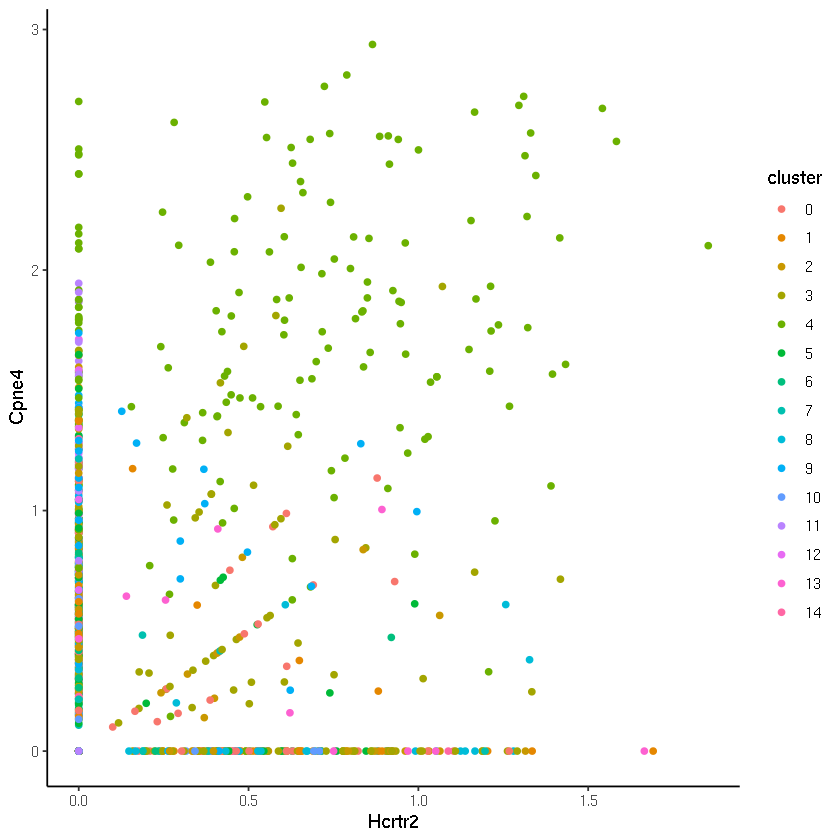

In [271]:
ggplot(data = digit.scatter.df, mapping= aes(x=Hcrtr2, y=Cpne4, color=cluster)) +geom_point() + theme_classic()

In [356]:
ff.module.exp <- first.alpha.integrated[['FF_Module1']][,1]
sf.module.exp <- first.alpha.integrated[['SF_Module1']][,1]
pc1.exp <- Embeddings(first.alpha, reduction = 'pca')[,1]
ff.pc1.scatter.df <- data.frame(PC_1 = pc1.exp, FF_Module=ff.module.exp, cluster=first.alpha.integrated$seurat_clusters)
sf.pc1.scatter.df <- data.frame(PC_1 = pc1.exp, SF_Module=sf.module.exp, cluster=first.alpha.integrated$seurat_clusters)

In [380]:
fig_4k <- ggplot(data = ff.pc1.scatter.df, mapping= aes(x=PC_1, y=FF_Module, color=cluster)) +geom_point() + theme_classic()
fig_4k <- fig_4k + geom_smooth(method='lm', mapping = aes(x=PC_1, y=FF_Module, color=NULL)) 
ggsave(filename = paste(graph.dir,'fig_4k.pdf'), plot= fig_4k, device = 'pdf')


fig_4k_1 <- ggplot(data = sf.pc1.scatter.df, mapping= aes(x=PC_1, y=SF_Module, color=cluster)) +geom_point() + theme_classic()

fig_4k_1 <- fig_4k_1 + geom_smooth(method='lm', mapping = aes(x=PC_1,y=SF_Module, color=NULL) )
ggsave(filename = paste(graph.dir,'fig_4k_1.pdf'), plot= fig_4k_1, device = 'pdf')

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



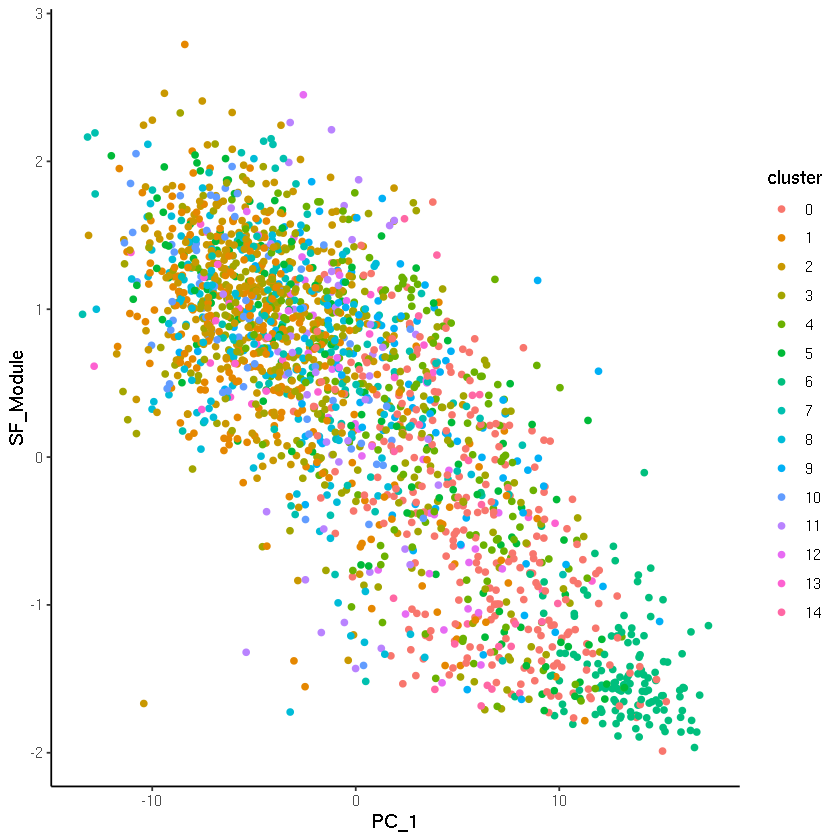

In [375]:
ggplot(data = sf.pc1.scatter.df, mapping= aes(x=PC_1, y=SF_Module, color=cluster)) +geom_point() + theme_classic()


In [384]:
cor(x=pc1.exp, y=ff.module.exp)**2

[1] 0.3096028

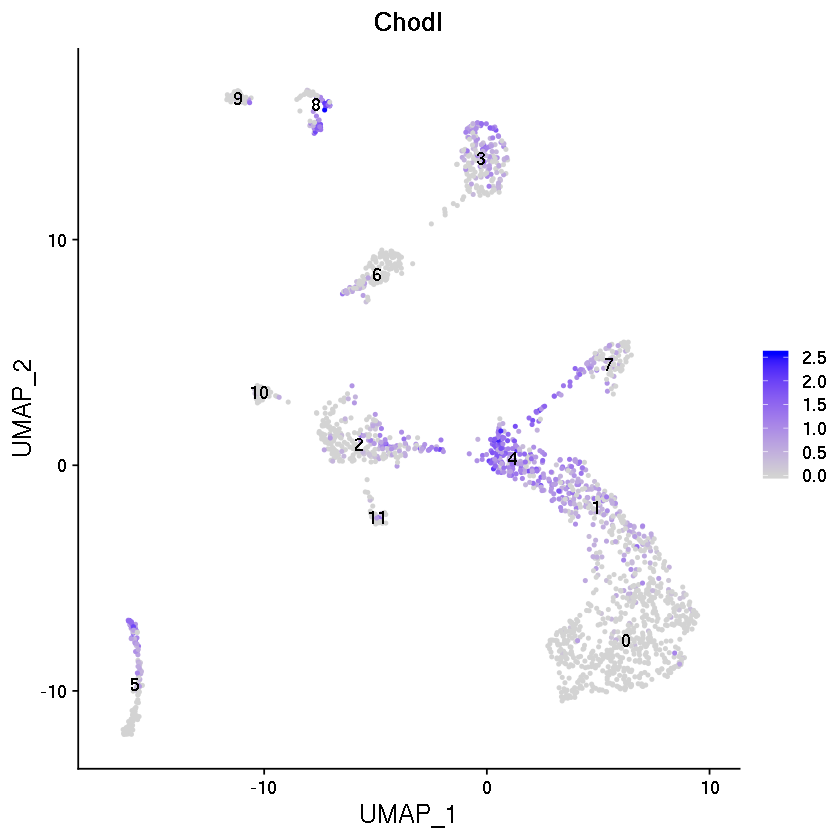

In [133]:
DefaultAssay(first.alpha.integrated) <- 'RNA'
FeaturePlot(first.alpha.integrated, features = c('Chodl'), label=T)

# Figure 1

In [39]:
DefaultAssay(all.exps.ctl.nodub) <- 'RNA'
fig_1b <- DimPlot(all.exps.ctl.nodub, label=T, label.size=5.5) + NoLegend() + NoAxes()
fig_1b_wlegend <-DimPlot(all.exps.ctl.nodub, label=T, label.size=5.5) + NoAxes()

In [ ]:
ggsave(filename = paste(graph.dir,'fig_1b.pdf'), plot= fig_1b, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_1b_wlegend.pdf'), plot= fig_1b_wlegend, device = 'pdf')


In [21]:
glut_markers <- c('Slc17a8', 'Slc17a6')
gaba_markers <- c('Gad1', 'Gad2')
glyc_markers <- c('Slc6a5')
astro_markers <- c('Gfap', 'Aqp4')
microglia_markers <- c('Cx3cr1', 'Trem2', 'P2ry12')
endo_markers <- c('Cldn5')
oligo_markers <- c('Mbp', 'Mobp')
cholin_markers <- c('Slc5a7', 'Chat')


In [22]:
all.markers <- c(glut_markers, gaba_markers, glyc_markers, astro_markers, microglia_markers, endo_markers, oligo_markers, cholin_markers)

In [23]:
all.heatmap.avgexp <- AverageExpression(all.exps.ctl.nodub, features=all.markers, assays = 'RNA')

Finished averaging RNA for cluster Microglia/Macrophages

Finished averaging RNA for cluster Astrocytes

Finished averaging RNA for cluster Endothelial cells

Finished averaging RNA for cluster Oligodendrocytes

Finished averaging RNA for cluster Cholinergic neurons

Finished averaging RNA for cluster Inhibitory neurons

Finished averaging RNA for cluster Excitatory neurons



In [38]:
library(ComplexHeatmap)
library(gplots)

In [25]:
# process data first: want to just show average expression per cluster for top X genes
all.heatmap.normexp <- all.heatmap.avgexp$RNA/rowMeans(all.heatmap.avgexp$RNA)
# all.exps.heatmap.normexp

In [35]:
pdf(file = paste(graph.dir, 'fig_1c.pdf'), height = 8, width = 8)
heatmap.2(as.matrix(all.heatmap.normexp),
    main = "Test", # heat map title
    notecol="black",      # change font color of cell labels to black
    density.info="none",  # turns off density plot inside color legend
    trace="none",         # turns off trace lines inside the heat map
#     margins =c(1,11),     # widens margins around plot
    dendrogram='both',     # only draw a row dendrogram
    Colv=T,
    Rowv=T,  
    key=T,
    col=colorRampPalette(c("white","red", "dark red", 'dark red'))(n = 40),
    symm=F,
    symbreaks=F,
    cexCol=1.2,
    srtCol=70,
    margins=c(12,12))
dev.off()

png 
  2

In [42]:
Idents(first.cholin) <- first.cholin$seurat_clusters
fig_1d <- DimPlot(first.cholin, label=T, label.size=5.5) + NoLegend() + NoAxes()
fig_1d_wlegend <-DimPlot(first.cholin, label=T, label.size=5.5) + NoAxes()

In [44]:
ggsave(filename = paste(graph.dir,'fig_1d.pdf'), plot= fig_1d, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_1d_wlegend.pdf'), plot= fig_1d_wlegend, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [18]:
DefaultAssay(first.cholin) <- 'RNA'
Idents(first.cholin) <- first.cholin$seurat_clusters
marker_exp_cholin <- AverageExpression(first.cholin, assays = 'RNA', features = c('Nos1', 'Anxa4', 'Pax2'))

Finished averaging RNA for cluster 0

Finished averaging RNA for cluster 1

Finished averaging RNA for cluster 2

Finished averaging RNA for cluster 3

Finished averaging RNA for cluster 4

Finished averaging RNA for cluster 5

Finished averaging RNA for cluster 6

Finished averaging RNA for cluster 7

Finished averaging RNA for cluster 8

Finished averaging RNA for cluster 9

Finished averaging RNA for cluster 10

Finished averaging RNA for cluster 11

Finished averaging RNA for cluster 12

Finished averaging RNA for cluster 13

Finished averaging RNA for cluster 14

Finished averaging RNA for cluster 15

Finished averaging RNA for cluster 16

Finished averaging RNA for cluster 17

Finished averaging RNA for cluster 18

Finished averaging RNA for cluster 19

Finished averaging RNA for cluster 20



In [26]:
cluster_order_nos1 <- names(marker_exp_cholin$RNA)[order(marker_exp_cholin$RNA[1,], decreasing = T)]
cluster_order_anxa4 <- names(marker_exp_cholin$RNA)[order(marker_exp_cholin$RNA[2,], decreasing = T)]
cluster_order_pax2 <- names(marker_exp_cholin$RNA)[order(marker_exp_cholin$RNA[3,], decreasing = T)]


In [28]:
Idents(first.cholin) <- factor(Idents(first.cholin), levels=cluster_order_nos1)
fig_1e_1 <- VlnPlot(first.cholin, features = c('Nos1')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
Idents(first.cholin) <- factor(Idents(first.cholin), levels=cluster_order_anxa4)

fig_1e_2 <- VlnPlot(first.cholin, features = c('Anxa4')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))

Idents(first.cholin) <- factor(Idents(first.cholin), levels=cluster_order_pax2)

fig_1e_3 <- VlnPlot(first.cholin, features = c('Pax2')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))


In [30]:
ggsave(filename = paste(graph.dir,'fig_1e_1.pdf'), plot= fig_1e_1, device = 'pdf', height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_1e_2.pdf'), plot= fig_1e_2, device = 'pdf', height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_1e_3.pdf'), plot= fig_1e_3, device = 'pdf', height = 5, width = 20)


In [3]:
names(table(first.cholin$cell_class))

[1] "Cholinergic INs" "Skeletal MNs"    "Visceral MNs"

In [158]:
DefaultAssay(first.cholin) <- 'RNA'
Idents(first.cholin) <- first.cholin$seurat_clusters
cholin.celltype.markers <- FindAllMarkers(first.cholin, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)



Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20



In [160]:
write.csv(file=paste(graph.dir,'cholin.celltype.markers.csv'), cholin.celltype.markers)

In [14]:
cholin.heatmap.markers <- data.frame()
cholin.celltypes <- names(table(first.cholin$cell_class))

for (cell_type in cholin.celltypes) {
    temp.celltype.markers <- cholin.celltype.markers[cholin.celltype.markers$cluster==cell_type,]
    cholin.heatmap.markers <- rbind(cholin.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:10,])
}
cholin.heatmap.markers <- na.omit(cholin.heatmap.markers)
cholin.names.heatmap <- cholin.heatmap.markers$gene

In [15]:
fig_1f <- DotPlot(object = first.cholin, features = unique(cholin.names.heatmap), dot.scale = 7 )+RotatedAxis()+
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 14), axis.title.x = element_text(size=24), axis.title.y=element_text(size=24))+
coord_flip() + ylab('Cluster')+ xlab('Gene')
ggsave(filename = paste(graph.dir,'fig_1f.pdf'), plot= fig_1f, device = 'pdf', height = 8, width = 9)


In [34]:
Idents(first.cholin) <- first.cholin$cell_class
fig_1g_supp <- DimPlot(first.cholin, label=T, label.size=5.5) + NoLegend() + NoAxes()
fig_1g_supp_wlegend <-DimPlot(first.cholin, label=T, label.size=5.5) + NoAxes()
ggsave(filename = paste(graph.dir,'fig_1g.pdf'), plot= fig_1g_supp, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_1g_wlegend.pdf'), plot= fig_1g_supp_wlegend, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [56]:
# all.exps.ctl.nodub$cell_type <- factor(all.exps.ctl.nodub$cell_type, levels=names(table(all.exps.ctl.nodub$cell_type))[2:8])
# freq.table <- NULL
freq.table <- data.frame(table(Idents(all.exps.ctl.nodub)))
names(freq.table) <- list('cell_type', 'freq')
freq.table$color=c(1:7)
freq.table <- freq.table[order(freq.table$freq, decreasing = TRUE),]
freq.table['percentage'] <- 100*(freq.table$freq/sum(freq.table$freq))

In [86]:
freq.table$ymax = cumsum(freq.table$percentage)

# Compute the bottom of each rectangle
freq.table$ymin = c(0, head(freq.table$ymax, n=-1))

freq.table$labelPosition <- (freq.table$ymax + freq.table$ymin) / 2
freq.table$label <- paste0(freq.table$cell_type, "\n value: ", freq.table$percentage)

fig_1a_2 <- ggplot(freq.table, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=cell_type)) +
     geom_rect() +
     coord_polar(theta="y") + # Try to remove that to understand how the chart is built initially
     xlim(c(2, 4)) + # Try to remove that to see how to make a pie chart)
#     geom_text( x=4, aes(y=labelPosition, label=label), size=6) +
    theme_classic() + NoAxes() 

In [88]:
ggsave(filename = paste(graph.dir,'fig_1a_2.pdf'), plot= fig_1a_2, device = 'pdf')


Saving 6.67 x 6.67 in image



# Figure 2

In [7]:
# allen_counts_file <- '/oak/stanford/groups/agitler/Jacob/single_cell_motor_neurons/allen_autonomic_counts.csv'

In [3]:
allen_counts_file <- 'allen_autonomic_counts.csv'

In [4]:
test_csv <- read.csv(allen_counts_file, stringsAsFactors = F)

In [5]:
gene.list <- unique(test_csv$X)
for (i in c(1:length(test_csv$X))) {
    test_csv[i,'mean'] <- mean(as.integer(test_csv[test_csv$X==test_csv$X[i],3])) 
}
test_csv['relative_num'] <- test_csv$number.of.cells/test_csv$mean

In [6]:
split_csv <- split(test_csv, test_csv$X)
model.df <- data.frame(x=seq(200,1475,0.1))
for (gene.dist in split_csv) {
    temp.df <- data.frame(x=gene.dist$slide.number, y=gene.dist$relative_num)
    temp.model <- lm(y ~ poly(x, 8), data=temp.df)
    pred.data <- data.frame(x=seq(200,1475,0.1))
    model.df[gene.dist$X[1]] <- predict(temp.model, pred.data)
}

In [6]:
# DefaultAssay(first.visceral) <- 'RNA'
# cluster3_markers <- FindMarkers(object = first.visceral, ident.1=3, only.pos=T)

In [107]:
# cluster3_markers <- cluster3_markers[order(cluster3_markers$pct.2),]

In [108]:
# print(noquote(toString(rownames(cluster3_markers)[1:300])))

In [109]:
# cluster7_markers <- FindMarkers(object = first.visceral, ident.1=7, only.pos = T)

In [110]:
# cluster7_markers <- cluster7_markers[order(cluster7_markers$pct.2),]
# print(noquote(toString(rownames(cluster7_markers)[1:300])))

In [12]:
cluster10_markers <- FindMarkers(object = first.visceral, ident.1=10, only.pos = T)

In [111]:
# cluster10_markers <- cluster10_markers[order(cluster10_markers$pct.2),]

# print(noquote(toString(rownames(cluster10_markers)[1:300])))


In [13]:
cluster4_markers <- FindMarkers(object = first.visceral, ident.1=4, only.pos = T)

In [112]:
# cluster4_markers <- cluster4_markers[order(cluster4_markers$pct.2),]

# print(noquote(toString(rownames(cluster4_markers)[1:300])))


In [14]:
cluster13_markers <- FindMarkers(object = first.visceral, ident.1=13, only.pos = T)

In [113]:
# cluster13_markers <- cluster13_markers[order(cluster13_markers$pct.2),]

# print(noquote(toString(rownames(cluster13_markers)[1:300])))


In [101]:
cluster1_markers <- FindMarkers(object = first.visceral, ident.1=1, only.pos = T)

In [114]:
# cluster1_markers <- cluster1_markers[order(cluster1_markers$pct.2),]

# print(noquote(toString(rownames(cluster1_markers)[1:300])))


In [103]:
cluster6_markers <- FindMarkers(object = first.visceral, ident.1=6, only.pos = T)

In [115]:
# cluster6_markers <- cluster6_markers[order(cluster6_markers$pct.2),]

# print(noquote(toString(rownames(cluster6_markers)[1:300])))


In [7]:

# AverageExpression(first.visceral, assays = 'RNA', features = c('Hhip', 'Nts', 'Col6a1', 'Crp', 'Eln))
# AverageExpression(first.visceral, assays = 'RNA', features = c('Gabrg1', 'Drd2', 'Eln'))
# AverageExpression(first.visceral, assays = 'RNA', features = c('Postn', 'Fbn2'))
visc.marker.exp <- AverageExpression(first.visceral, assays = 'RNA', features = colnames(model.df)[-1])


Finished averaging RNA for cluster 0

Finished averaging RNA for cluster 1

Finished averaging RNA for cluster 2

Finished averaging RNA for cluster 3

Finished averaging RNA for cluster 4

Finished averaging RNA for cluster 5

Finished averaging RNA for cluster 6

Finished averaging RNA for cluster 7

Finished averaging RNA for cluster 8

Finished averaging RNA for cluster 9

Finished averaging RNA for cluster 10

Finished averaging RNA for cluster 11

Finished averaging RNA for cluster 12

Finished averaging RNA for cluster 13

Finished averaging RNA for cluster 14

Finished averaging RNA for cluster 15



In [8]:
# colMax <- function(data) sapply(data, max, na.rm = TRUE)

visc.log2fc.markers <- log2(visc.marker.exp$RNA/rowMeans(visc.marker.exp$RNA))

In [9]:
visc.log2fc.markers[visc.log2fc.markers < 0] <- 0

In [118]:
library(formattable)

In [21]:
# cluster_ids <- c( 'Cluster 3', 'Cluster 7', 'Cluster 10',  'Cluster 4', 'Cluster 13', 'Cluster 1')
# spatial_loc <- c('Sacral', 'Sacral', 'Sacral', 'Upper Thoracic', 'Upper Thoracic','Lumbar')
# neuroactive_pep <- c('Penk, Sst, Cartpt', 'None', 'Ngf', 'Bdnf, Eln', 'Fstl4, Kitl, Tnr, Angpt1', 'Kitl, Spock3, Cartpt, Crp, Bmper')
# synaptic_rec <- c('Grm1, Grm8, Glra2, Gria3, Chrm3', 'Grid1, Grm1, Grin3a, Grm7, Glra1', 'Piezo2, Cnr1, Grm8', 'Gabra2, Gabrb1, Gabrg1, Gabrg3, Grin3a, Gria1, Grid1, Grik1, Grm1, Grm7', 'Chrm2, Gabra2, Gabrb1, Gabrg1, Gabrg3, Grin3a, Gria2, Grin2b, Grm3', 'Chrm2, Grm5')


In [20]:
# table_2f <- data.frame(Cluster=cluster_ids, 'Spatial Localization'=spatial_loc, 'Neuroactive Peptides'=neuroactive_pep, 'Postsynaptic Receptors'=synaptic_rec)


In [10]:
normal.vec <- rep(0.0,34)
normal.vec[3] <- 1.0
normal.vec[24] <- 1.0
visc.log2fc.markers$'16' <- normal.vec

In [11]:
cumulative.model <- data.frame(as.matrix(model.df[,-1]) %*% as.matrix(visc.log2fc.markers))

In [12]:
cumulative.model.adj <- data.frame(x=model.df$x)
for (i in 1:length(cumulative.model)) {
    cumulative.model.adj[paste('cluster',i-1,sep = '_')] <- cumulative.model[,i]/max(cumulative.model[,i])

}

# cumulative.model.adj <- cumulative.model*(1/colMax(cumulative.model))

In [39]:
library(reshape2)
library(scales)

In [84]:
sacral.clusters <- data.frame(x=cumulative.model.adj$x, y=rowMeans(cumulative.model.adj[,c('cluster_3', 'cluster_7')]))

In [15]:
fig2_cp <- hue_pal()(16)

In [86]:
# ggplot(data = sacral.clusters, mapping = aes(x=x,y=y)) + geom_area(fill=fig2_cp[1]) +ylim(0,1) + theme_classic()

In [16]:
cumul.melted <- melt(cumulative.model.adj, variable.name='cluster', id.vars='x')

In [17]:
cumul.melted <- cumul.melted[is.finite(cumul.melted$value),]

In [32]:
# ggplot(data = cumul.melted, mapping = aes(x=x, y=value, colour=cluster)) +geom_area() + ylim(0,1) + NoLegend()

In [33]:
# library(ggpubr)
# ggarrange(ncol=4,nrow=4)

In [34]:
# print(cumul.melted[cumul.melted$cluster=='X0',])

n

cluster 0: thoracic, upper thoracic, lumbosacral
cluster 1: thoracic, lumbosacral, upper thoracic
cluster 2: thoracic, upper thoracic
cluster 3: sacral, 
cluster 4: upper thoracic, lumbosacral
cluster 5: thoracic?, upper thoracic
cluster 6: thoracic
cluster 7: sacral
cluster 8: upper thoracic, lumbosacral
cluster 9: ? lumbosacral
cluster 10: thoracic, some upper? , lumbosacral
cluster 11: thoracic? upper thoracic, lumbo
cluster 12: 
cluster 13: upper thoracic
cluster 14: thoracic
cluster 15: thoracic, upper thoracic


In [118]:
DefaultAssay(first.visceral) <- 'RNA'
fig_2a <- DimPlot(first.visceral, label=T, label.size=5.5) + NoLegend() + scale_color_manual(values = fig2_cp) + NoAxes()

In [139]:
DefaultAssay(first.cholin) <- 'RNA'
fig_2a_inset <- DimPlot(first.cholin, group.by='cell_class') + NoLegend() + NoAxes() + scale_color_manual(values=c('grey', 'grey', 'blue'))

The following functions and any applicable methods accept the dots: CombinePlots



In [135]:
DefaultAssay(first.cholin) <- 'RNA'
fig_2h_inset <- DimPlot(first.cholin, group.by='cell_class') + NoLegend() + NoAxes() + scale_color_manual(values=c('blue', 'grey', 'grey'))

In [138]:
DefaultAssay(first.visceral) <- 'RNA'
fig_2h <- DimPlot(first.inter, label=T, label.size=5.5) + NoLegend() + NoAxes()

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


In [85]:
plot.normal.line <- function(input.df) {
    temp.df <- input.df[c(1,18)]
    temp.melted <- melt(temp.df, variable.name='cluster', id.vars='x')
    temp.melted <- temp.melted[is.finite(temp.melted$value),]
    
    temp.fig <- ggplot(data = temp.melted, mapping = aes(x=x, y=value, fill=cluster)) +geom_line(alpha=0.5, position=position_identity())  + ylim(0,1) +xlim(1500, 325) + theme_classic() 
    temp.fig
}


In [18]:
plot.sacral.markers <- function(input.df, clust.num) {
    temp.df <- input.df[c(1,clust.num+2)]
    temp.melted <- melt(temp.df, variable.name='cluster', id.vars='x')
    temp.melted <- temp.melted[is.finite(temp.melted$value),]
    
    temp.fig <- ggplot(data = temp.melted, mapping = aes(x=x, y=value, fill=cluster)) +geom_area(alpha=0.5, position=position_identity()) + scale_fill_manual(values = fig2_cp[clust.num+1]) + ylim(0,1) +xlim(1500, 325) + theme_classic() 
    temp.fig
}


In [164]:
plot.markers.with.norm <- function(input.df, clust.num) {
    temp.df <- input.df[c(1,clust.num+2)]
    temp.melted <- melt(temp.df, variable.name='cluster', id.vars='x')
    temp.melted <- temp.melted[is.finite(temp.melted$value),]
    

    normal.df <- input.df[c(1,18)]
    norm.melted <- melt(normal.df, variable.name='normal', id.vars='x')
    norm.melted <- norm.melted[is.finite(norm.melted$value),]
    
    
    temp.fig <- ggplot(data = temp.melted, mapping = aes(x=x, y=value, fill=cluster)) +geom_area(alpha=0.5, position=position_identity()) + scale_fill_manual(values = c('black',fig2_cp[clust.num+1])) + ylim(0,1) +xlim(1500, 325) + theme_classic() 
    temp.fig <- temp.fig + geom_line(data = norm.melted, mapping = aes(x=x, y=value, fill='black'), alpha=1)
    temp.fig
}


In [42]:
fig2_cp[c(3,5)]

[1] "#CD9600" "#7CAE00"

In [166]:
fig2_d1 <- plot.sacral.markers(cumulative.model.adj, clust.num=c(10,3,7)) + NoAxes()
# fig2_d1_nolegend <- plot.sacral.markers(cumulative.model.adj, clust.num=c(10,3,7)) + NoLegend()

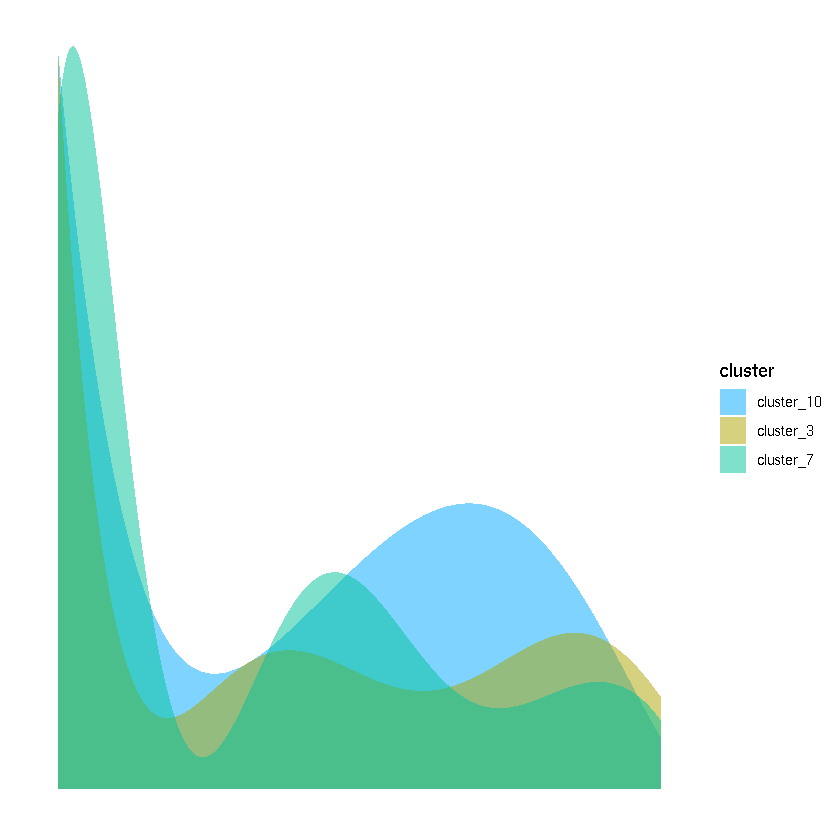

In [168]:
fig2_d1

In [21]:
fig2_d1 <- plot.sacral.markers(cumulative.model.adj, clust.num=c(10,3,7)) + NoAxes()
fig2_d2 <- plot.sacral.markers(cumulative.model.adj, clust.num=c(4,13))+ NoAxes()
fig2_d3 <- plot.sacral.markers(cumulative.model.adj, clust.num=c(6))+ NoAxes()
fig2_d4 <- plot.sacral.markers(cumulative.model.adj, clust.num=c(0,2,5,14,15))+ NoAxes()
fig2_d5 <- plot.sacral.markers(cumulative.model.adj, clust.num=c(11,8))+ NoAxes()

In [22]:
ggsave(filename = paste(graph.dir,'fig_2d_1.pdf'), plot= fig2_d1, device = 'pdf', height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_2d_2.pdf'), plot= fig2_d2, device = 'pdf',height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_2d_3.pdf'), plot= fig2_d3, device = 'pdf',height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_2d_4.pdf'), plot= fig2_d4, device = 'pdf',height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_2d_5.pdf'), plot= fig2_d5, device = 'pdf',height = 4, width = 20)
# ggsave(filename = paste(graph.dir,'fig_2a.pdf'), plot= fig_2a, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_2a_inset.pdf'), plot= fig_2a_inset, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_2h_inset.pdf'), plot= fig_2h_inset, device = 'pdf')
# ggsave(filename = paste(graph.dir,'fig_2h.pdf'), plot= fig_2h, device = 'pdf')



# Supplemental Figure S2

In [173]:
fig_s2_1 <- plot.markers.with.norm(cumulative.model.adj, clust.num=c(6))+ NoAxes()
fig_s2_2 <- plot.markers.with.norm(cumulative.model.adj, clust.num=c(13,4)) + NoAxes()
fig_s2_3 <- plot.markers.with.norm(cumulative.model.adj, clust.num=c(10,3,7)) + NoAxes()
fig_s2_4 <- plot.markers.with.norm(cumulative.model.adj, clust.num=c(11,8)) + NoAxes()
fig_s2_5 <- plot.markers.with.norm(cumulative.model.adj, clust.num=c(0,2,5,14,15)) + NoAxes()


Warning message:
“Ignoring unknown aesthetics: fill”
Warning message:
“Ignoring unknown aesthetics: fill”
Warning message:
“Ignoring unknown aesthetics: fill”
Warning message:
“Ignoring unknown aesthetics: fill”
Warning message:
“Ignoring unknown aesthetics: fill”


In [175]:
ggsave(filename = paste(graph.dir,'fig_s2_1.pdf'), plot= fig_s2_1, device = 'pdf', height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_s2_2.pdf'), plot= fig_s2_2, device = 'pdf',height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_s2_3.pdf'), plot= fig_s2_3, device = 'pdf',height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_s2_4.pdf'), plot= fig_s2_4, device = 'pdf',height = 4, width = 20)
ggsave(filename = paste(graph.dir,'fig_s2_5.pdf'), plot= fig_s2_5, device = 'pdf',height = 4, width = 20)

Warning message:
“Removed 2516 rows containing missing values (geom_path).”
Warning message:
“Removed 2516 rows containing missing values (geom_path).”
Warning message:
“Removed 2516 rows containing missing values (geom_path).”
Warning message:
“Removed 2516 rows containing missing values (geom_path).”
Warning message:
“Removed 2516 rows containing missing values (geom_path).”


In [ ]:
+scale_fill_manual(fig2_cp[clust.num])

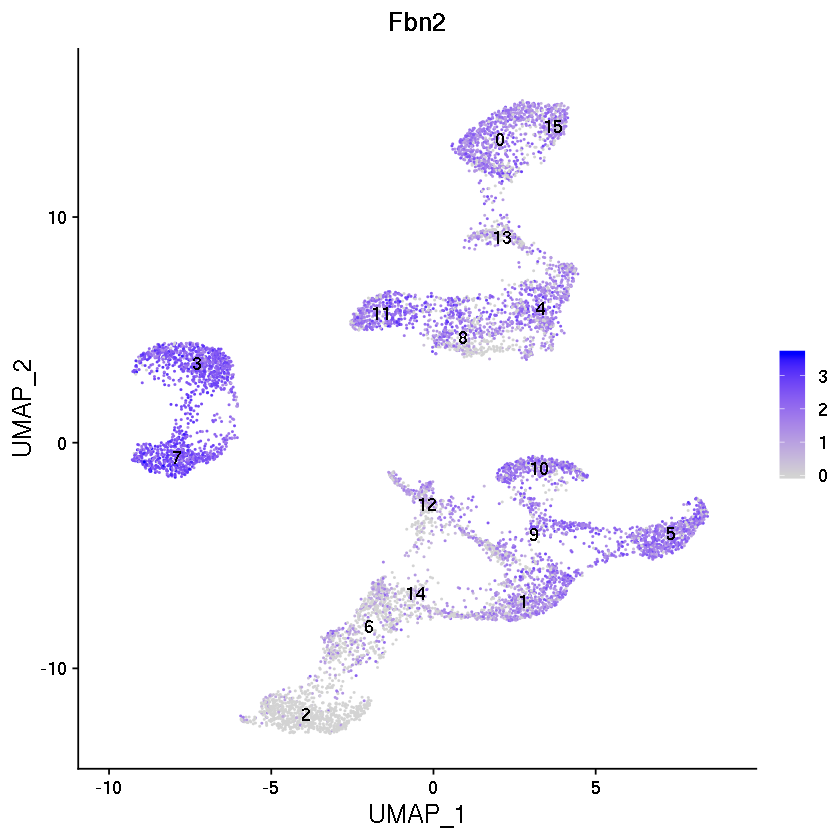

In [211]:
DefaultAssay(first.visceral) <- 'RNA'
FeaturePlot(first.visceral, features = c('Fbn2'), label=T)

In [30]:
DefaultAssay(first.gad2) <- 'integrated' 
first.gad2 <- find.pcs.and.clustids(first.gad2)

Centering and scaling data matrix

PC_ 1 
Positive:  Nlgn1, Csmd2, Dlg2, Rgs6, Pard3b, Sdk2, Pitpnc1, Sgcd, Dlgap2, Kirrel3 
	   Unc13c, Gfra1, Chrm3, Mctp1, Cdh11, Cobll1, Pcdh7, 9530026P05Rik, Msi2, Igsf3 
	   Plxdc2, Ngef, St6galnac5, Bcl2, Pcsk6, Cntnap5b, Kcnip3, Cmip, Dmd, Ctnna2 
Negative:  Gpc5, Sorbs2, Pcdh9, Grm5, Ptprt, Asic2, Adcy8, Ptprm, Inpp4b, Thsd7a 
	   Cntn3, Nxph1, 9530059O14Rik, Adarb1, Cntn6, Nrg3, Nkain3, Dlgap1, March1, Rapgef4 
	   Tenm4, Kif26b, Med12l, Epha5, Lrrtm4, Ephb1, Vwa5b2, Ncam2, Fam13a, Ntm 
PC_ 2 
Positive:  Lrrc4c, Net1, Gpc6, Hs6st3, Raver2, Ptprm, Cadm1, Inpp4b, St3gal4, Dnm3 
	   Afap1, Fam155a, Csmd2, Rab31, Miat, Fstl5, Dgkb, Sdk2, Acad10, Trpm3 
	   Mdga2, Clstn3, Cntn5, Zfp804b, Kcnab2, Nxph1, Mast4, Galnt14, Gm45321, Gm46430 
Negative:  Nkain2, Gabrg3, Asic2, Grid2, Kirrel3, Nkain3, Nrg1, Grid1, Grm5, Lrrc7 
	   Med12l, Jcad, Cers6, Epha5, Tshz2, Atp5c1, Adgrg6, Pygb, Slc4a8, Zscan20 
	   Bcl6, Atrn, 2210408I21Rik, Caln1, Gpc5, Brinp1, Cnt

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1083
Number of edges: 57915

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7989
Number of communities: 5
Elapsed time: 0 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


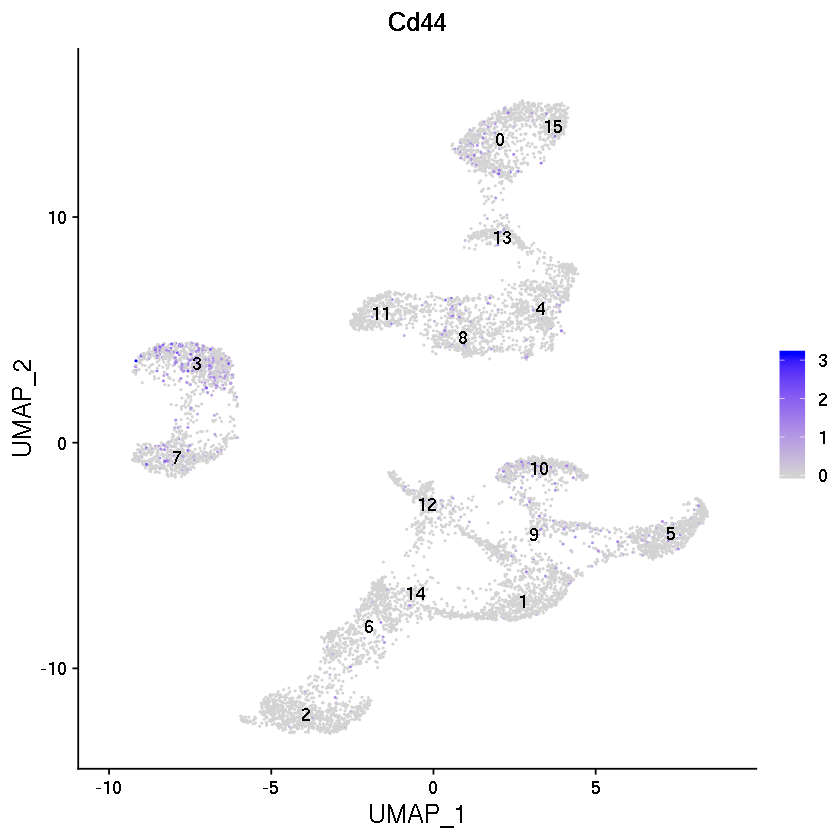

In [12]:
DefaultAssay(first.visceral) <- 'RNA'
FeaturePlot(first.visceral, features = c('Cd44'), label=T)

# FIGURE 3

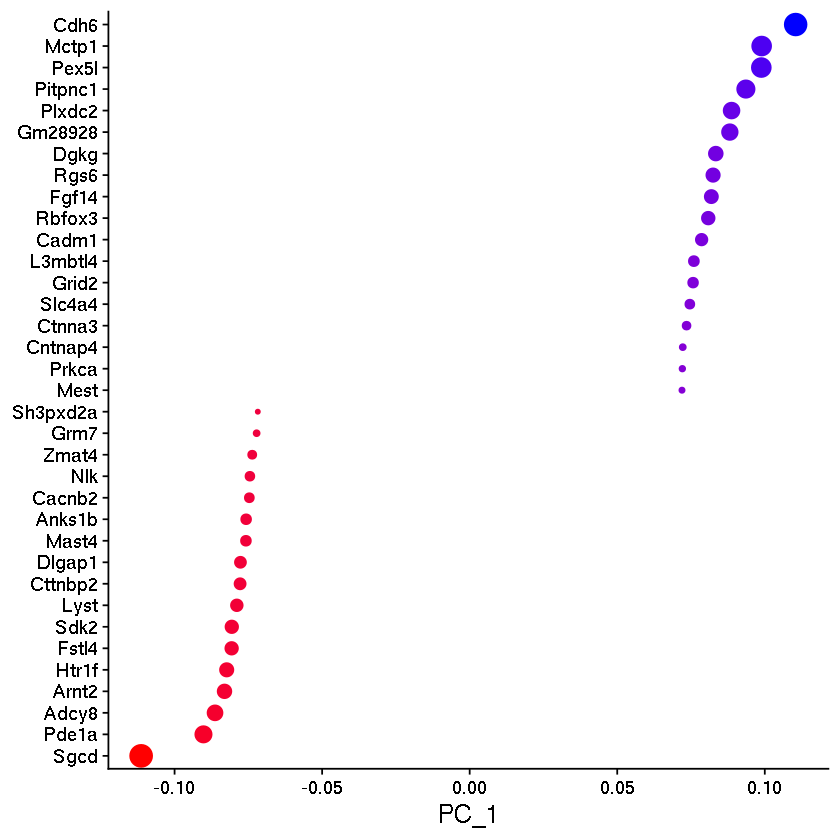

In [154]:
fig_3s <- VizDimLoadings(first.alpha, dims=c(1), nfeatures=35) 
fig_3s$layers <- NULL
fig_3s <- fig_3s + geom_point(aes(x=PC_1, y=feature, color=PC_1, size=abs(PC_1))) + scale_color_gradient(low = 'red', high = 'blue') + NoLegend()
fig_3s

In [296]:
test.loadings <- Loadings(first.alpha.integrated, reduction='pca')

In [316]:
test.loadings[,1]['Stac2']

Stac2 
0.04482697

In [40]:
library(XML)
testresult <- xmlToDataFrame('IMLC_genes.xml', stringsAsFactors = FALSE)


In [41]:
library(ComplexHeatmap)
library(gplots)

In [ ]:
# process data first: want to just show average expression per cluster for top X genes


In [ ]:
heatmap.2(log.sod.genechange,
    cellnote = abs(sod.genechange),  # same data set for cell labels
    main = "DE genes", # heat map title
    notecol="black",      # change font color of cell labels to black
    density.info="none",  # turns off density plot inside color legend
    trace="none",         # turns off trace lines inside the heat map
    margins =c(14,14),     # widens margins around plot
    dendrogram='none',     # only draw a row dendrogram
    Colv="NA",
    Rowv='NA',  
    key=F,
    col=my_palette,
    symm=T,
    cexCol=1.2,
    srtCol=70)  
dev.off()

In [17]:
annotatedVisceral <- testresult$`gene-symbol`

In [45]:
allgenes <- rownames(first.visceral@assays$RNA@counts)

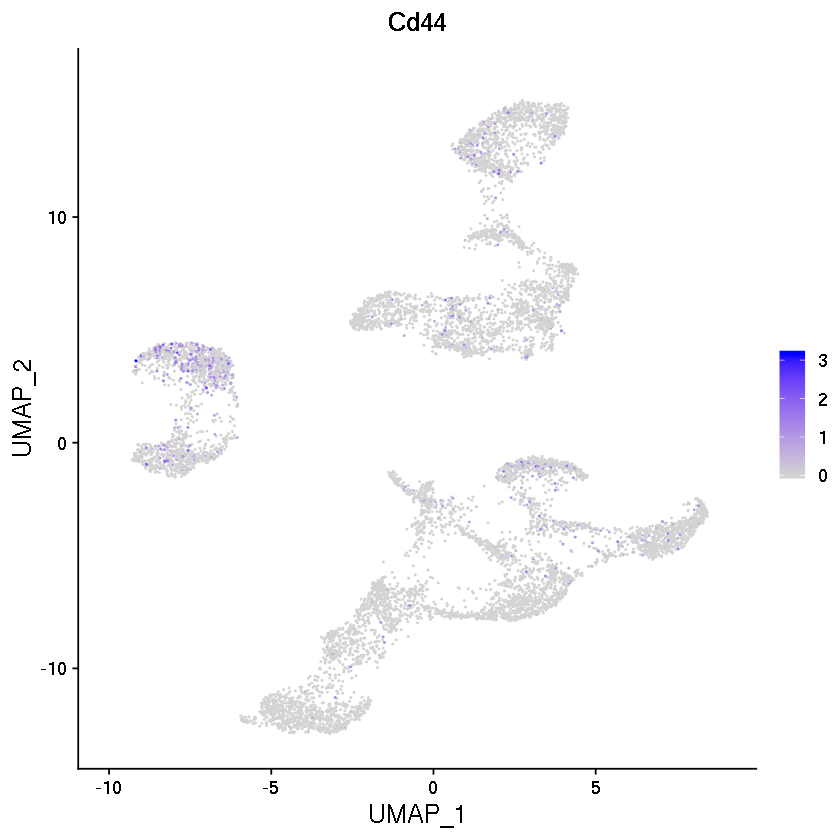

In [85]:
DefaultAssay(first.visceral) <- 'RNA'
FeaturePlot(first.visceral, features = c('Cd44'))

In [135]:
setdiff(annotatedVisceral, allgenes)

ERROR: Error in as.vector(x): object 'annotatedVisceral' not found


In [10]:
# DefaultAssay(first.visceral) <- 'RNA'
# visceral.celltype.markers <- FindAllMarkers(first.visceral, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)

DefaultAssay(first.inter) <- 'RNA'
inter.celltype.markers <- FindAllMarkers(first.inter, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)


# DefaultAssay(first.skeletal) <- 'RNA'
# inter.celltype.skeletal <- FindAllMarkers(first.inter, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)



Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7



In [11]:
write.csv(file=paste(graph.dir,'inter.celltype.markers.csv'), inter.celltype.markers)

In [49]:
visceral.heatmap.markers <- data.frame()
for (c.num in c(0:15)) {
    temp.celltype.markers <- visceral.celltype.markers[visceral.celltype.markers$cluster==c.num,]
    visceral.heatmap.markers <- rbind(visceral.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:2,])
}
visceral.heatmap.markers <- na.omit(visceral.heatmap.markers)
visceral.names.heatmap <- visceral.heatmap.markers$gene

In [75]:
skeletal.heatmap.markers <- data.frame()
for (cell_type in skeletal.cell.labels) {
    temp.celltype.markers <- skeletal.cellclass.markers[skeletal.cellclass.markers$cluster==cell_type,]
    skeletal.heatmap.markers <- rbind(skeletal.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:10,])
}
skeletal.heatmap.markers <- na.omit(skeletal.heatmap.markers)
skeletal.names.heatmap <- skeletal.heatmap.markers$gene

In [180]:
inter.heatmap.markers <- data.frame()
for (c.num in c(0:7)) {
    temp.celltype.markers <- inter.celltype.markers[inter.celltype.markers$cluster==c.num,]
    temp.celltype.markers <- temp.celltype.markers[temp.celltype.markers$avg_logFC>1,]
    temp.celltype.markers <- temp.celltype.markers[str_detect(temp.celltype.markers$gene, 'Gm1', negate=T),]

    inter.heatmap.markers <- rbind(inter.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:4,])
}
inter.heatmap.markers <- na.omit(inter.heatmap.markers)
inter.names.heatmap <- inter.heatmap.markers$gene

In [42]:
library(scales)
fig2_color_palette <- hue_pal()(length(skeletal.list) + length(visceral.list) + length(inter.list))

In [30]:
# fig_2i <- DoHeatmap(object=first.skeletal,features=skeletal.names.heatmap, label = FALSE, group.colors = fig2_color_palette[c(3,6,9)])+scale_fill_viridis_c(option='inferno') + theme(axis.text.y = element_text(size = 5))
# fig_2j <- DoHeatmap(object=first.inter,features=inter.names.heatmap, label = FALSE, group.colors = fig2_color_palette[c(2,5,8)])+scale_fill_viridis_c(option='inferno') + theme(axis.text.y = element_text(size = 5))
#  <- DoHeatmap(object=first.visceral,features=visceral.names.heatmap, label = FALSE)

In [86]:
fig_2e <- DotPlot(object = first.visceral, features = unique(visceral.names.heatmap), dot.scale = 7 )+RotatedAxis()+
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 14), axis.title.x = element_text(size=24), axis.title.y=element_text(size=24))+
coord_flip() + ylab('Cluster')+ xlab('Gene')
ggsave(filename = paste(graph.dir,'fig_2e.pdf'), plot= fig_2e, device = 'pdf', height = 8, width = 9)


In [184]:
fig_2i <- DotPlot(object = first.inter, features = unique(inter.names.heatmap))+RotatedAxis()+
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 14), axis.title.x = element_text(size=24), axis.title.y=element_text(size=24))+
coord_flip() + ylab('Cluster')+ xlab('Gene')
ggsave(filename = paste(graph.dir,'fig_2i.pdf'), plot= fig_2i, device = 'pdf', height = 8, width = 9)


In [191]:
DefaultAssay(first.inter) <- 'RNA'
fig_2j_legend <- FeaturePlot(first.inter, label=T, label.size=5.5, features = c('Pitx2')) + NoAxes() +
theme(title=element_text(size=20))
fig_2j_nolegend <- fig_2j_legend+NoLegend()

In [192]:
ggsave(filename = paste(graph.dir,'fig_2j.pdf'), plot= fig_2j, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2j_nolegend.pdf'), plot= fig_2j_nolegend, device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [25]:
DefaultAssay(first.visceral) <- 'RNA'
Idents(first.visceral) <- first.visceral$seurat_clusters
visceral.celltype.markers <- FindAllMarkers(first.visceral, max.cells.per.ident = 100, logfc.threshold = 0.5, only.pos=TRUE)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [65]:
write.csv(file=paste(graph.dir,'visceral.celltype.markers.csv'), visceral.celltype.markers)

In [61]:
visc.1.genes <-as.vector(visceral.celltype.markers$p_val_adj[visceral.celltype.markers$cluster==1])
names(visc.1.genes) <-  as.vector(visceral.celltype.markers$gene[visceral.celltype.markers$cluster==1])

In [140]:
fig_2c_0 <- VlnPlot(object = first.visceral, features = 'Trhr', pt.size = 0, log = T)
fig_2c_1 <- VlnPlot(object = first.visceral, features = 'Cartpt', pt.size = 0, log = T)
fig_2c_2 <- VlnPlot(object = first.visceral, features = 'Mdga1', pt.size = 0, log = T)
fig_2c_3 <- VlnPlot(object = first.visceral, features = 'Slc26a7', pt.size = 0, log = T)
fig_2c_4 <- VlnPlot(object = first.visceral, features = 'Fras1', pt.size = 0, log = T)
fig_2c_5 <- VlnPlot(object = first.visceral, features = 'Gpc3', pt.size = 0, log = T)
fig_2c_6 <- VlnPlot(object = first.visceral, features = 'Gas7', pt.size = 0, log = T)
fig_2c_7 <- VlnPlot(object = first.visceral, features = 'Rxfp1', pt.size = 0, log = T)
fig_2c_8 <- VlnPlot(object = first.visceral, features = 'Agbl1', pt.size = 0, log = T)
fig_2c_9 <- VlnPlot(object = first.visceral, features = 'Mamdc2', pt.size = 0, log = T)
fig_2c_10 <- VlnPlot(object = first.visceral, features = 'Fam19a1', pt.size = 0, log = T)
fig_2c_11 <- VlnPlot(object = first.visceral, features = 'Synpr', pt.size = 0, log = T)
fig_2c_12 <- VlnPlot(object = first.visceral, features = 'Mpped2', pt.size = 0, log = T)
fig_2c_13 <- VlnPlot(object = first.visceral, features = 'Fstl4', pt.size = 0, log = T)

# fig_2c_14 <- VlnPlot(object = first.visceral, features = 'Zfp536', pt.size = 0, log = T)
fig_2c_15 <- VlnPlot(object = first.visceral, features = 'Trhr', pt.size = 0, log = T)



In [13]:
top.visc.markers <- visceral.celltype.markers[order(visceral.celltype.markers$pct.2),]$gene[1:5]

In [72]:
ordered.visceral.markers <- visceral.celltype.markers[order(visceral.celltype.markers$pct.2-visceral.celltype.markers$pct.1),]

In [193]:
# ordered.visceral.markers[ordered.visceral.markers$cluster==15,]

In [ ]:
visceral.celltype.markers[visceral.celltype.markers$cluster==16,]

In [194]:
# print(visceral.celltype.markers[visceral.celltype.markers$cluster==1,])

In [8]:
fig_3b <-DimPlot(first.skeletal, label=T, label.size=7) + NoLegend() + NoAxes()
ggsave(filename = paste(graph.dir,'fig_3b.pdf'), plot= fig_3b, device = 'pdf')


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Saving 6.67 x 6.67 in image



In [ ]:
fig_3b_inset <-DimPlot(first.skeletal, label=T, label.size=7) + NoLegend() + NoAxes()
ggsave(filename = paste(graph.dir,'fig_3b.pdf'), plot= fig_3b, device = 'pdf')


In [6]:
DefaultAssay(first.cholin) <- 'RNA'
fig_3b_inset <- DimPlot(first.cholin, group.by='cell_class') + NoLegend() + NoAxes() + scale_color_manual(values=c('grey', 'blue', 'grey'))
ggsave(filename = paste(graph.dir,'fig_3b_inset.pdf'), plot= fig_3b_inset, device = 'pdf')


Saving 6.67 x 6.67 in image



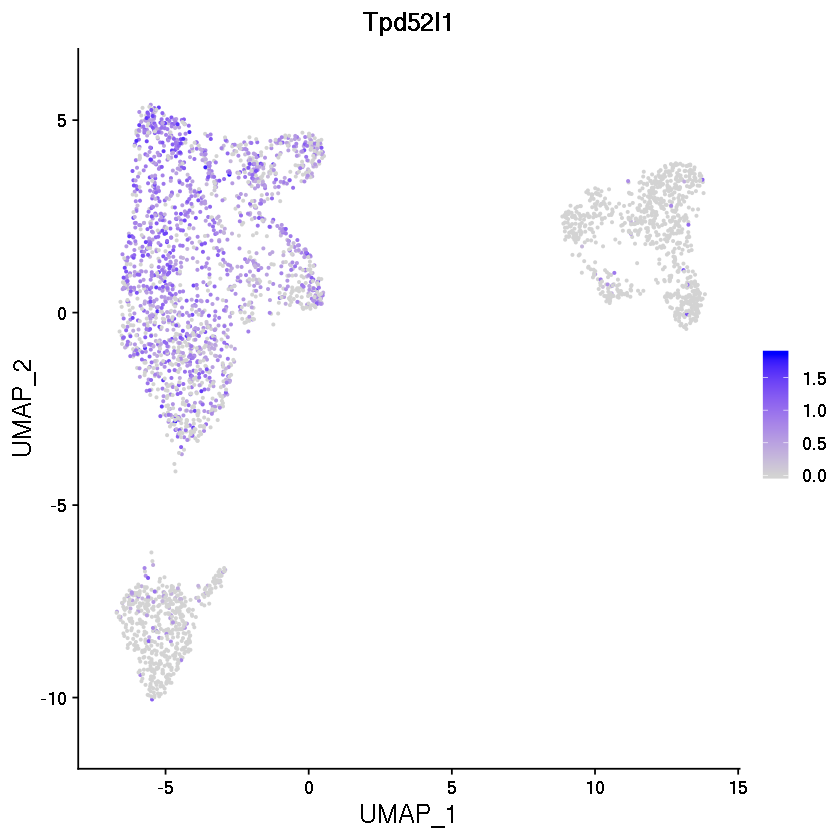

In [92]:
FeaturePlot(first.skeletal, features = 'Tpd52l1')

In [320]:
DefaultAssay(first.skeletal) <- 'RNA'
fig_3c_1 <- VlnPlot(first.skeletal, features = c('Htr1d')) + NoLegend() +
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_3c_2 <- VlnPlot(first.skeletal, features = c('Rbfox3')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_3c_3 <- VlnPlot(first.skeletal, features = c('Spp1')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))

In [321]:
ggsave(filename = paste(graph.dir,'fig_3c_1.pdf'), plot= fig_3c_1, device = 'pdf', height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_3c_2.pdf'), plot= fig_3c_2, device = 'pdf', height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_3c_3.pdf'), plot= fig_3c_3, device = 'pdf', height = 5, width = 20)


In [132]:
alpha.v.gamma <- FindMarkers(first.skeletal, ident.1=c(1,3,4,5,7,8,9,10), max.cells.per.ident = 150, logfc.threshold = .3, only.pos =T)

In [133]:
gamma.v.alpha <- FindMarkers(first.skeletal, ident.1=c(2,0,6), max.cells.per.ident = 150, logfc.threshold = .3, only.pos =T)

In [151]:
print(alpha.v.gamma[order(alpha.v.gamma$pct.2),])

                     p_val avg_logFC pct.1 pct.2    p_val_adj
Mrvi1         1.345077e-26 0.4882757 0.582 0.006 3.371974e-22
Chodl         2.664802e-18 0.4807257 0.387 0.007 6.680391e-14
Gm14697       1.345077e-26 0.6186844 0.654 0.010 3.371974e-22
Plxdc1        8.333333e-22 0.3699649 0.448 0.015 2.089083e-17
Maf           2.794415e-17 0.3826581 0.451 0.020 7.005320e-13
Col4a5        4.555522e-19 0.3576778 0.466 0.024 1.142024e-14
Cacna1g       6.601203e-29 0.4158091 0.587 0.028 1.654856e-24
Rspo2         1.497008e-22 0.4540314 0.460 0.030 3.752850e-18
Sema3d        1.314570e-17 0.3075273 0.387 0.030 3.295496e-13
Col5a3        9.542404e-15 0.3277075 0.462 0.032 2.392185e-10
Popdc3        1.047670e-20 0.3881305 0.519 0.036 2.626404e-16
Dscaml1       2.204911e-13 0.3108971 0.364 0.051 5.527490e-09
Spint2        3.125439e-10 0.3689716 0.289 0.055 7.835162e-06
Col5a1        1.333595e-19 0.5223175 0.511 0.058 3.343190e-15
Tpd52l1       3.483376e-28 0.5426882 0.659 0.059 8.732475e-24
2900055J

In [170]:
alpha.gamma.dotplot.features <- c('Syt17', 'Npas1', 'Stac', 'Car2', 'Kcnk13', 'Pnoc', 'Htr1d',
                                 'Mrvi1', 'Cacna1g', 'Sema3d', 'Col4a5', 'Col5a3', 'Popdc3', 
                                  'Tpd52l1', 'Col5a1', 'Glis3', 'Sv2b', 'Vipr2', 'Stk32a',
                                 'Tacr1', 'Ecel1', 'Lypd6', 'Chst9', 'Kcnt2', 'Maf', 'Rspo2', 'Spint2', 
                                 'Aox1', 'Adra1a', 'Dock2')

In [14]:
DefaultAssay(first.skeletal) <- 'RNA'
Idents(first.skeletal) <- factor(Idents(first.skeletal), levels=c(0,2,6,10,1,3,4,5,7,8,9))
fig_3d <- DotPlot(first.skeletal, features = alpha.gamma.dotplot.features,dot.scale = 10 ) +
theme(axis.text.x = element_text(size = 25), axis.text.y = element_text(size = 25), axis.title.x = element_text(size=30), axis.title.y=element_text(size=24))+
coord_flip() + ylab('Cluster')+ xlab('Gene')
ggsave(filename = paste(graph.dir,'fig_3d.pdf'), plot= fig_3d, device = 'pdf', height = 10, width = 20)


In [171]:
skeletal.heatmap.avgexp <- AverageExpression(first.skeletal, features=alpha.gamma.dotplot.features, assays = 'RNA')

Finished averaging RNA for cluster 0

Finished averaging RNA for cluster 2

Finished averaging RNA for cluster 6

Finished averaging RNA for cluster 10

Finished averaging RNA for cluster 1

Finished averaging RNA for cluster 3

Finished averaging RNA for cluster 4

Finished averaging RNA for cluster 5

Finished averaging RNA for cluster 7

Finished averaging RNA for cluster 8

Finished averaging RNA for cluster 9



In [38]:
skeletal.heatmap.avgexp

In [43]:
library(ComplexHeatmap)
library(gplots)

In [172]:
# process data first: want to just show average expression per cluster for top X genes
skeletal.heatmap.normexp <- skeletal.heatmap.avgexp$RNA
# skeletal.heatmap.normexp

In [78]:
pdf(file = paste(graph.dir, 'fig_3d_2.pdf'), height = 8, width = 8)
heatmap.2(as.matrix(skeletal.heatmap.normexp),
    main = "Alpha and Gamma Marker Genes", # heat map title
    notecol="black",      # change font color of cell labels to black
    density.info="none",  # turns off density plot inside color legend
    trace="none",         # turns off trace lines inside the heat map
#     margins =c(1,11),     # widens margins around plot
    dendrogram='both',     # only draw a row dendrogram
    Colv=T,
    Rowv=T,  
    key=T,
    col=colorRampPalette(c("white","red", "dark red", 'dark red'))(n = 40),
    symm=F,
    symbreaks=F,
    cexCol=1.2,
    srtCol=70)
dev.off()

ERROR: Error in as.matrix(skeletal.heatmap.normexp): object 'skeletal.heatmap.normexp' not found


In [47]:
skeletal.cell.labels <- c('Alpha Motor Neurons', 'Gamma Motor Neurons')
inter.cell.labels <- c('Cholinergic partition cells', 'Cholinergic GABA INs', 'Cholinergic Glycine INs')
visceral.cell.labels <- c('Postn+ sympathetic MNs', 'Smoc2+ sympathetic MNs', 'Rxfp1+ parasympathetic MNs', 'Cdh6+ visceral MNs')


alpha.clusters <- c(1,3,4,5,7,8,9,10)
gamma.clusters <- c(2,0,6)


partition.clusters <- c(0,1)
inhib.gaba.clusters <- c(2,3,4,6,7)
inhib.glycin.clusters <- c(5)


postn.pregang <- c(4,8,11)
smoc2.pregang <- c(0,13,15)
cdh6.pregang <- c(1,2,5,6,9,10,12,14)
rxfp1.pregang <- c(3,7)


skeletal.list <- list(alpha.clusters, gamma.clusters)
inter.list <- list(partition.clusters, inhib.gaba.clusters, inhib.glycin.clusters)
visceral.list <- list(postn.pregang, smoc2.pregang, cdh6.pregang, rxfp1.pregang)


In [48]:
Idents(first.skeletal) <- first.skeletal$seurat_clusters
# first.skeletal <- reset.ids(first.skeletal,ident1.list=skeletal.list, ident2.label='skeletal_subtype', skeletal.cell.labels)
# Idents(first.skeletal) <- first.skeletal$skeletal_subtype

In [49]:
first.alpha <- subset(first.skeletal, idents=alpha.clusters)
DefaultAssay(first.alpha) <- 'RNA'
first.alpha.list <- SplitObject(first.alpha, split.by='orig.ident')

first.alpha.anchors <- FindIntegrationAnchors(object.list = first.alpha.list, k.filter=40)
first.alpha.integrated <- IntegrateData(anchorset = first.alpha.anchors, dims = 1:10)

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

No variable features found for object4 in the object.list. Running FindVariableFeatures ...

No variable features found for object5 in the object.list. Running FindVariableFeatures ...

No variable features found for object6 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 475 anchors

Filtering anchors

	Retained 316 anchors

Extracting within-dataset neighbors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 465 anchors

Filtering anchors

	Retained 381 anchors

Extracting within-dataset neighbors

In [50]:
first.alpha.integrated <- find.pcs.and.clustids(first.alpha.integrated, pc.dims = 10)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Centering and scaling data matrix

PC_ 1 
Positive:  Pex5l, Grip1, Cacna2d3, Rspo2, 4930419G24Rik, Cdh6, Lrrtm3, Ptprd, Chodl, Ctnna3 
	   Nkain2, Rgs7bp, Csmd3, Mctp1, Pdgfd, Dgkg, Zfp804a, Sorcs3, Ano4, Plxdc2 
	   Plxdc1, Ano3, Poln, Sv2b, Pcdh7, Rimbp2, Etl4, Megf11, Csgalnact1, Mcc 
Negative:  Kcnq3, Luzp2, Cacna2d1, Mast4, Pde1a, Arnt2, Sgcd, Rora, Kcnn3, Rmst 
	   Shisa9, Slc44a5, Crtac1, Grm1, Robo2, Celf4, Astn2, Plcl2, Ptpro, Dner 
	   Kcnd2, Htr1f, Cobl, Kcnc2, Hdac9, Esrrg, Gm43122, Tmem132d, Rreb1, AC129186.1 
PC_ 2 
Positive:  Rora, Vav3, Sgcd, Plch1, Grm7, Dlgap2, Frmpd4, Adcy8, Sdk2, Esrrg 
	   Cdh20, Galnt18, Dner, Spock3, Etl4, Sorcs1, Luzp2, Pcdh15, Pde10a, Gm21798 
	   Crtac1, Man1a, Pcdh7, Robo1, Grm1, Actn2, Rerg, Zmat4, Ntng1, Il1rapl1 
Negative:  Negr1, Kcnip4, Sema6d, Kcnt2, Asic2, Slc8a1, Atp8a1, Mpped2, Nav2, Grik1 
	   Atp2b4, Dgkh, Prkca, Cdh8, Cacna1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2023
Number of edges: 64005

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8989
Number of communities: 12
Elapsed time: 0 seconds


In [51]:
first.alpha.integrated <- RunUMAP(first.alpha.integrated, dims=c(1:10), seed.use=4, n.neighbors = 40L, spread = 1.5)

18:35:29 UMAP embedding parameters a = 0.5595 b = 1.003

18:35:29 Read 2023 rows and found 10 numeric columns

18:35:29 Using Annoy for neighbor search, n_neighbors = 40

18:35:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

18:35:30 Writing NN index file to temp file /tmp/RtmplIDLjW/file2518b58234c36

18:35:30 Searching Annoy index using 8 threads, search_k = 4000

18:35:30 Annoy recall = 100%

18:35:30 Commencing smooth kNN distance calibration using 8 threads

18:35:31 Initializing from normalized Laplacian + noise

18:35:31 Commencing optimization for 500 epochs, with 105384 positive edges

18:35:38 Optimization finished



Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: TRUE”


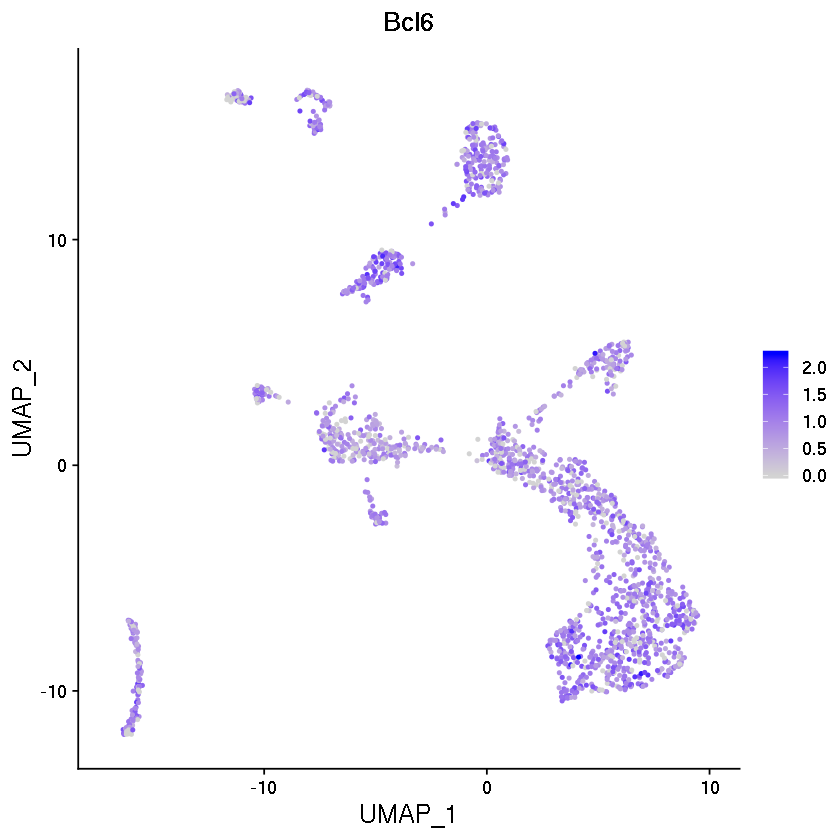

In [53]:
DefaultAssay(first.alpha.integrated) <- 'RNA'
FeaturePlot(first.alpha.integrated, features=c('Bcl6', label=T))

In [54]:
# Umap  blowouts  for preganglionic, skeletal, and interneurons
DefaultAssay(first.skeletal) <- 'integrated'
Idents(first.skeletal) <- first.skeletal$seurat_clusters
first.alpha <- find.pcs.and.clustids(subset(first.skeletal, idents=alpha.clusters))
first.gamma <- find.pcs.and.clustids(subset(first.skeletal, idents=gamma.clusters))



Centering and scaling data matrix

PC_ 1 
Positive:  Cdh6, Mctp1, Pex5l, Pitpnc1, Plxdc2, Gm28928, Dgkg, Rgs6, Fgf14, Rbfox3 
	   Cadm1, L3mbtl4, Grid2, Slc4a4, Ctnna3, Cntnap4, Prkca, Mest, Map7d1, Pde4b 
	   Nkain2, Clstn2, Mmp16, Ptprj, 9530059O14Rik, Cacna1a, Frmd4b, Mcu, Grin2b, Lrrc7 
Negative:  Sgcd, Pde1a, Adcy8, Arnt2, Htr1f, Fstl4, Sdk2, Lyst, Cttnbp2, Dlgap1 
	   Mast4, Anks1b, Cacnb2, Nlk, Zmat4, Grm7, Sh3pxd2a, Cobl, March11, Fam155a 
	   Pcdh9, Cdh20, Plcl2, Ssbp2, Nos1ap, Elovl5, Rasa4, Trpm3, AC149090.1, Ikzf2 
PC_ 2 
Positive:  Vav3, Sgcz, Nrp1, Dlgap2, Nrg1, Pcdh7, Sv2b, Lrrc4c, Slc7a14, Prune2 
	   Gria3, Zfpm2, Cdh20, Nkain2, Nhs, Il1rapl1, Dlgap1, Kalrn, Phactr1, Ppm1e 
	   Itpr1, Cdh18, Csmd1, Camta1, Thrb, Nlgn1, Adgrb3, Rgs7bp, Map2, Ppp2r2b 
Negative:  Mpped2, Celf4, Asic2, Kcnip4, Gap43, Fnbp1l, Nav2, Camk2a, Hmcn1, Kcnd2 
	   Fam19a1, Grm5, Prkg1, Sgsm2, Chrm3, Ddx5, Zfp536, Nsg2, Osbpl3, Mctp2 
	   Cadps2, Pbx3, Dock10, Chl1, Klhl1, Cachd1, Ncam1, CT025619.1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2023
Number of edges: 100758

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8369
Number of communities: 9
Elapsed time: 0 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Klhl1, Pard3b, Creb5, Kif26b, Tshz2, Kcnd2, Pcdh7, Prkg1, Plekhg1, Dlg2 
	   Dab1, Pam, Pde4b, Htr1f, Cdh11, Pitpnc1, Prr16, Pde4d, Ncam1, Lrrtm4 
	   Vwc2, Cers6, Cntnap4, St6galnac5, Kirrel3, Ralyl, Csmd2, Fnbp1l, Gm26883, Pbx3 
Negative:  Stxbp6, Sgcd, Sgcz, Man1a, Auts2, Svil, Plcl1, Nos1ap, Ssbp2, Dmd 
	   Zmat4, Gpc5, Pcp4l1, Clvs1, Itga6, Elovl5, Cdh20, Ptprg, Ctnna2, L3mbtl4 
	   Ptprz1, Efr3b, Adcy8, Usp53, Vav3, Itpr1, Kcnj3, C530008M17Rik, Pde1a, Slit3 
PC_ 2 
Positive:  Kcnip4, Trpm3, Fxyd7, Sdk1, Fstl5, Pde1a, Unc13c, Stk32a, Grm5, Chl1 
	   Rab31, 9530059O14Rik, Garnl3, Mctp2, Osbpl3, Sorbs2, Zkscan5, Tapt1, Sbno2, Galnt13 
	   Fam19a1, Stat3, Rps6ka5, Gpi1, Agpat4, Etnk1, Ubr5, Nav2, Fam120b, Cntn4 
Negative:  Caln1, Nrg1, Opcml, Kcnma1, Dab1, Magi2, Nlgn1, Cntnap5b, Lrrc4c, Kirrel3 
	   Inpp4b, Dlgap1, Gabrg3, Pacsin1, Anks1b, Zfp536, Gpc6, March11, Adgrv1, Gria3 
	   Ephb1, Msi2, Slc12a5, Timm17a, Camta1, Nxph1, Dock

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1282
Number of edges: 83789

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8002
Number of communities: 4
Elapsed time: 0 seconds


In [55]:
first.alpha <- RunUMAP(first.alpha, dims=c(1:15), seed.use=3, n.neighbors = 40L, spread = 5)
first.gamma <- RunUMAP(first.gamma, dims=c(1:10), seed.use=6, n.neighbors = 40L, spread = 4)

18:38:40 UMAP embedding parameters a = 0.1102 b = 0.8526

18:38:40 Read 2023 rows and found 15 numeric columns

18:38:40 Using Annoy for neighbor search, n_neighbors = 40

18:38:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

18:38:40 Writing NN index file to temp file /tmp/RtmplIDLjW/file2518b2f44a92a

18:38:40 Searching Annoy index using 8 threads, search_k = 4000

18:38:41 Annoy recall = 100%

18:38:41 Commencing smooth kNN distance calibration using 8 threads

18:38:42 Initializing from normalized Laplacian + noise

18:38:42 Commencing optimization for 500 epochs, with 106572 positive edges

18:38:48 Optimization finished

18:38:48 UMAP embedding parameters a = 0.1496 b = 0.8684

18:38:48 Read 1282 rows and found 10 numeric columns

18:38:48 Using Annoy for nei

In [122]:
gamma.exp.mat <- as.matrix(GetAssayData(first.gamma, assay='RNA'))

In [59]:
DefaultAssay(first.gamma) <- 'RNA'

In [22]:
cor.mat <- cor(gamma.exp.mat, gamma.exp.mat, method='spearman')

In [182]:
fig_3f <-DimPlot(first.gamma, label=T, label.size=7) + NoLegend() + NoAxes()
ggsave(filename = paste(graph.dir,'fig_3f.pdf'), plot= fig_3f, device = 'pdf')


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Saving 6.67 x 6.67 in image



In [57]:
DefaultAssay(first.skeletal) <- 'RNA'
fig_3f_inset <- DimPlot(first.skeletal, group.by='skeletal_subtype') + NoLegend() + NoAxes() + scale_color_manual(values=c('blue', 'grey'))
ggsave(filename = paste(graph.dir,'fig_3f_inset.pdf'), plot= fig_3f_inset, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_3f_inset.pdf'), plot= fig_3f_inset, device = 'pdf')



ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'skeletal_subtype' in this Seurat object


In [60]:
fig_3g_1 <- VlnPlot(first.gamma, features = c('Stxbp6')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_3g_2 <- VlnPlot(first.gamma, features = c('Pard3b')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_3g_3 <- VlnPlot(first.gamma, features = c('Creb5')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_3g_4 <- VlnPlot(first.gamma, features = c('Plch1')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))

In [61]:
ggsave(filename = paste(graph.dir,'fig_3g_1.pdf'), plot= fig_3g_1, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_3g_2.pdf'), plot= fig_3g_2, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_3g_3.pdf'), plot= fig_3g_3, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_3g_4.pdf'), plot= fig_3g_4, device = 'pdf',height = 5, width = 20)


In [24]:
DefaultAssay(first.gamma) <- 'RNA'
gamma.celltype.markers <- FindAllMarkers(first.gamma, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [227]:
gamma.v.beta.markers <- FindMarkers(first.gamma, ident.1= c(0,2,3), logfc.threshold=0.5, max.cells.per.ident = 100, only.pos=TRUE)

In [228]:
beta.v.gamma.markers <- FindMarkers(first.gamma, ident.1= c(1), logfc.threshold=0.5, max.cells.per.ident = 100, only.pos=TRUE)

## MAKE A HEATMAP WITH TOP GAMMA MARKERS, HIERARCHICAL CLUSTERING. 

In [36]:
gamma.heatmap.markers <- data.frame()
for (c.num in c(0:3)) {
    temp.celltype.markers <- gamma.celltype.markers[gamma.celltype.markers$cluster==c.num,]
    gamma.heatmap.markers <- rbind(gamma.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2-temp.celltype.markers$pct.1),][1:8,])
}
gamma.heatmap.markers <- na.omit(gamma.heatmap.markers)
gamma.names.heatmap <- gamma.heatmap.markers$gene

In [37]:
gamma.exp.mat <- GetAssayData(first.gamma, assay = 'RNA')
gamma.heat.mat <- gamma.exp.mat[gamma.names.heatmap,]

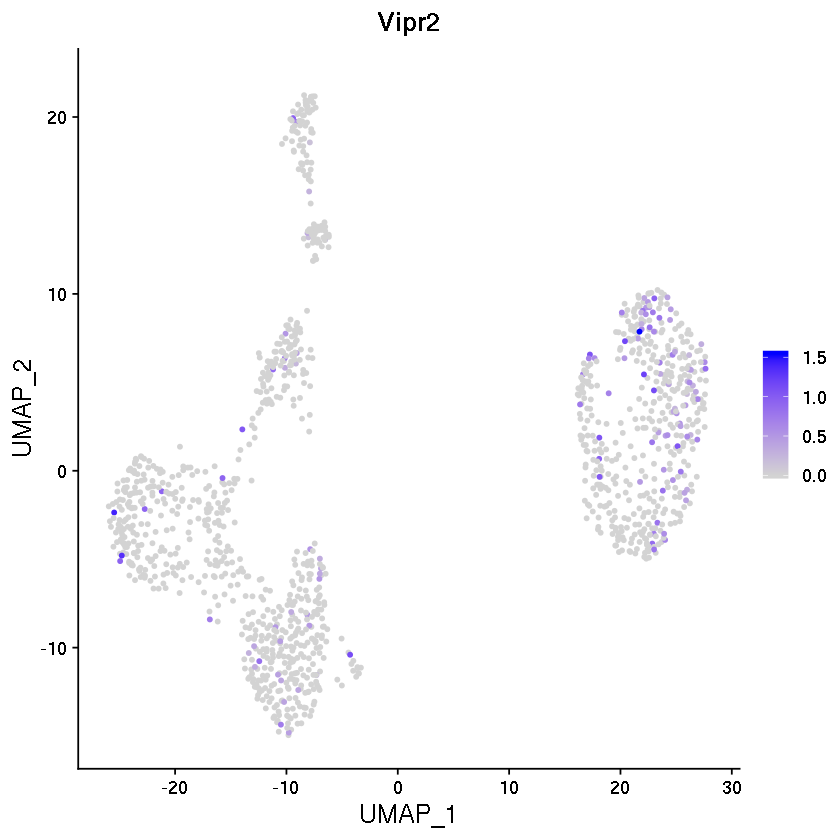

In [43]:
FeaturePlot(first.gamma, 'Vipr2')

In [55]:
first.alpha.integrated

An object of class Seurat 
52138 features across 2023 samples within 3 assays 
Active assay: integrated (2000 features)
 2 other assays present: RNA, first.integrated
 2 dimensional reductions calculated: pca, umap

In [176]:
pdf(file = paste(graph.dir, 'fig_s5a.pdf'), height = 8, width = 12)
heatmap.2(as.matrix(gamma.heat.mat),
    main = "Test", # heat map title
    notecol="black",      # change font color of cell labels to black
    density.info="none",  # turns off density plot inside color legend
    trace="none",         # turns off trace lines inside the heat map
#     margins =c(1,11),     # widens margins around plot
    dendrogram='both',     # only draw a row dendrogram
    Colv=T,
    Rowv=T,  
    key=T,
    col=colorRampPalette(c("white","red", "dark red", 'dark red'))(n = 40),
    symm=F,
    symbreaks=F,
    cexCol=1.2,
    srtCol=70,
    margins=c(12,12))
dev.off()

png 
  2

In [25]:
gamma.dotplot.markers <- data.frame()
for (c.num in c(0:3)) {
    temp.celltype.markers <- gamma.celltype.markers[gamma.celltype.markers$cluster==c.num,]
    gamma.dotplot.markers <- rbind(gamma.dotplot.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:4,])
}
gamma.dotplot.markers <- na.omit(gamma.dotplot.markers)
gamma.names.dotplot <- gamma.dotplot.markers$gene

In [27]:
DefaultAssay(first.gamma) <- 'RNA'
Idents(first.gamma) <- first.gamma$seurat_clusters
# Idents(first.gamma) <- factor(Idents(first.gamma), levels=c(1,0,2,3))
fig_3i <- DotPlot(first.gamma, features = gamma.names.dotplot,dot.scale = 15 ) +
theme(axis.text.x = element_text(size = 25), axis.text.y = element_text(size = 25), axis.title.x = element_text(size=30), axis.title.y=element_text(size=24))+
coord_flip() + ylab('Cluster')+ xlab('Gene')
ggsave(filename = paste(graph.dir,'fig_3i.pdf'), plot= fig_3i, device = 'pdf', height = 7, width = 10)

In [230]:
print(noquote(toString(rownames(gamma.v.beta.markers)[1:300])))

[1] Pard3b, Sema3c, Klhl1, Nrp2, Creb5, Tshz2, Grip1, Pam, Kif26b, Kcnd2, Prkg1, Pcdh7, Cacng3, Pde4b, Sema6d, Dab1, Dlg2, Cdh11, Gm26883, Slc8a1, Plekhg1, Samd5, Htr1f, Csmd2, Nwd2, Pkp4, Vwc2, Grin2a, Pitpnc1, Ryr3, Col27a1, Pbx3, Atp2b4, D5Ertd615e, Palld, Ralyl, Opcml, Adamts16, Kcnj6, Adamtsl3, Slc35f4, Ncam1, Gria1, Lgr5, Cdk14, Tspan18, Pard3bos1, Neto1, Pkib, Grm8, Tmem132d, Lrrtm4, Mthfd1l, Vwc2l, Prr16, Hs3st4, Nxph1, Pappa, Sash1, Cntnap5c, Htr2a, Pde4d, Cdh13, Ncald, Nrip1, Prkd1, Otof, C78859, Cntnap4, Rhoq, Pcnx, Prima1, Palmd, Azin2, Rai14, Chsy3, Ret, Nckap5, Stac, Smoc1, Xylt1, Gm48749, St6galnac5, Glis1, Sema5a, Robo2, Egflam, Kcnk10, Grik1, Dkk2, Nkain3, Slc44a5, Alcam, Cpne8, Dach1, Sytl2, Nup93, Gm32647, Col4a2, Cers6, Ptpro, Car10, Frmd4b, Tenm2, Dcc, Rnf152, Hcrtr2, Ltbp1, Pak1, Gpc6, Grm5, Kcnip4, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,

In [232]:
print(noquote(toString(rownames(beta.v.gamma.markers)[1:300])))

[1] Stxbp6, Rora, Sgcd, Gpr149, Sgcz, Galnt18, Rtl4, Sphkap, Plch1, Cacna1c, Crtac1, Trpc5, Frmpd4, Svil, Man1a, Cdh12, Dmd, Ssbp2, Nos1ap, Pcdh15, Plcl1, Nyap2, Ctnna2, Luzp2, Auts2, Cacna1d, Sntg1, Cntnap5a, Mical2, Lrp1b, Pcp4l1, Kitl, Slit3, Rps6ka3, L3mbtl4, Adamts2, Rreb1, Pdgfd, Nell2, C530008M17Rik, Slc24a3, Anks1b, Pdzrn4, Prkcd, Gpc5, Cdh20, Zmat4, Dner, Nlk, Pde10a, Cntnap3, Spock1, Grin2b, A830082K12Rik, C1qtnf4, Kcnj3, Nfia, Epha4, AC129186.1, Rasgrf1, Dync1i1, Gm15398, Epb41l4b, Tmem108, Gem, Utrn, Ajap1, Rph3a, Sipa1l3, Nrxn3, Lancl3, Rcan2, D430041D05Rik, Mlip, Pde1a, Ptprz1, Clvs1, Spock3, Grm1, Nr3c1, Ptprg, Sntg2, AC124490.1, Elovl5, Trps1, Grm7, Gna14, Sh3d19, Camk1d, Adcy8, Dlgap2, Pvt1, Sipa1l1, Nav3, Galnt16, Gm43122, Efr3b, Rerg, Bmpr1b, Lingo2, Edil3, Gfod1, Antxr1, Slc10a7, Sema6a, Mitf, Iqsec1, Vav3, Elmo1, Sorcs1, Cntn5, Ntng1, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 

# Figure 4

In [87]:
fig_4b <-DimPlot(first.alpha.integrated, label=T, label.size=7) + NoLegend() + NoAxes()
ggsave(filename = paste(graph.dir,'fig_4b.pdf'), plot= fig_4b, device = 'pdf')


Saving 6.67 x 6.67 in image



In [282]:
DefaultAssay(first.skeletal) <- 'RNA'
fig_4b_inset <- DimPlot(first.skeletal, group.by='skeletal_subtype') + NoLegend() + NoAxes() + scale_color_manual(values=c('grey', 'blue'))
ggsave(filename = paste(graph.dir,'fig_4b_inset.pdf'), plot= fig_4b_inset, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_4b_inset.pdf'), plot= fig_4b_inset, device = 'pdf')



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [137]:
DefaultAssay(first.alpha.integrated) <- 'RNA'
alpha.integrated.celltype.markers <- FindAllMarkers(first.alpha.integrated, logfc.threshold = 0.5, max.cells.per.ident = 50, only.pos=TRUE)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [93]:

alpha.integrated.heatmap.markers <- data.frame()
for (cell_type in c(0:9)) {
    temp.celltype.markers <- alpha.integrated.celltype.markers[alpha.integrated.celltype.markers$cluster==cell_type,]
    alpha.integrated.heatmap.markers <- rbind(alpha.integrated.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2-temp.celltype.markers$pct.1),][1:3,])
}
alpha.integrated.heatmap.markers <- na.omit(alpha.integrated.heatmap.markers)
alpha.integrated.names.heatmap <- unique(alpha.integrated.heatmap.markers$gene)

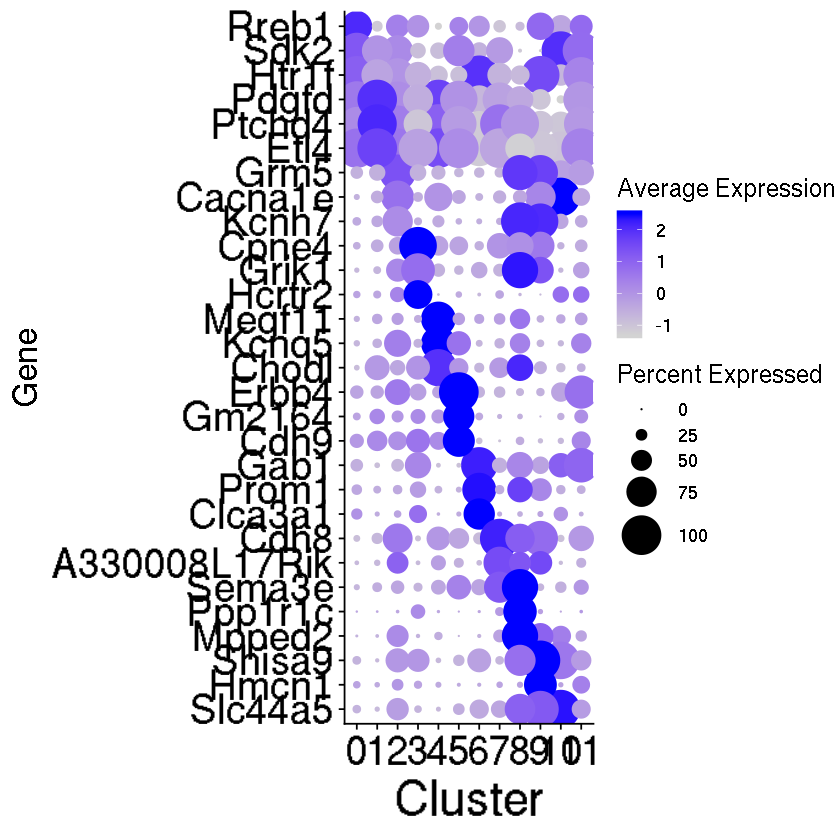

In [94]:
DefaultAssay(first.alpha.integrated) <- 'RNA'
Idents(first.alpha.integrated) <- first.alpha.integrated$seurat_clusters
# Idents(first.alpha.integrated) <- factor(Idents(first.alpha.integrated), levels=c(1,0,2,3))
fig_4c <- DotPlot(first.alpha.integrated, features = alpha.integrated.names.heatmap,dot.scale = 10.5 ) +
theme(axis.text.x = element_text(size = 25), axis.text.y = element_text(size = 25), axis.title.x = element_text(size=30), axis.title.y=element_text(size=24))+
coord_flip() + ylab('Cluster')+ xlab('Gene')
fig_4c
ggsave(filename = paste(graph.dir,'fig_4c.pdf'), plot= fig_4c, device = 'pdf', height = 10, width = 15)

In [95]:
fig_4d_1 <- VlnPlot(first.alpha.integrated, features = c('Hcrtr2')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4d_2 <- VlnPlot(first.alpha.integrated, features = c('Cdh8')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4d_3 <- VlnPlot(first.alpha.integrated, features = c('Sema3e')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4d_4 <- VlnPlot(first.alpha.integrated, features = c('Prom1')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4d_5 <- VlnPlot(first.alpha.integrated, features = c('Piezo2')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4d_6 <- VlnPlot(first.alpha.integrated, features = c('Erbb4')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))

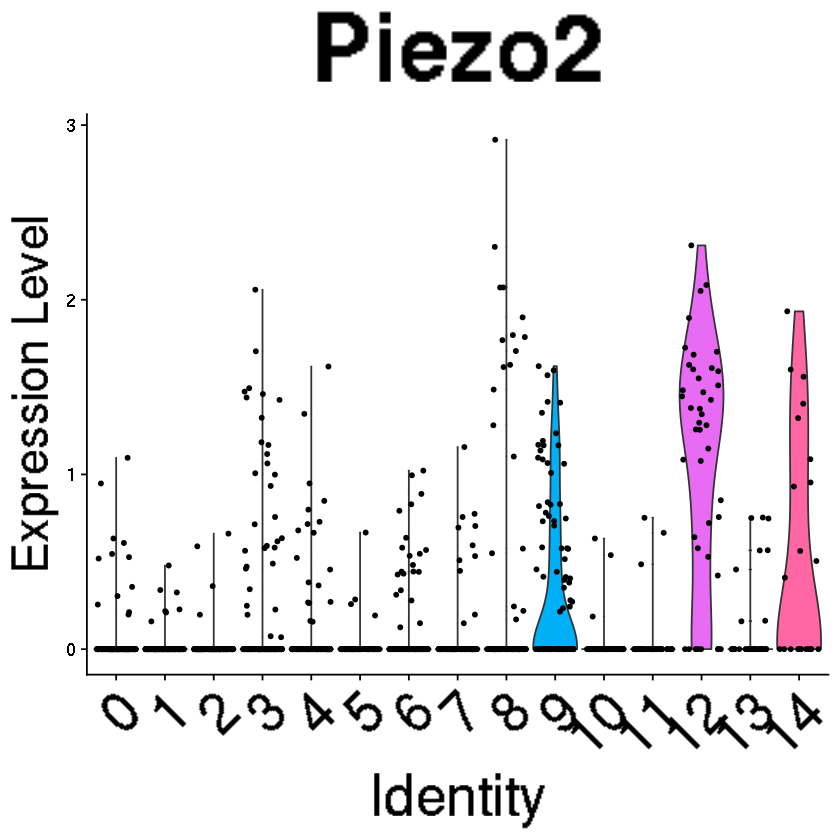

In [268]:
fig_4d_5

In [96]:
ggsave(filename = paste(graph.dir,'fig_4d_1.pdf'), plot= fig_4d_1, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4d_2.pdf'), plot= fig_4d_2, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4d_3.pdf'), plot= fig_4d_3, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4d_4.pdf'), plot= fig_4d_4, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4d_5.pdf'), plot= fig_4d_5, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4d_6.pdf'), plot= fig_4d_6, device = 'pdf',height = 5, width = 20)


In [99]:
fig_4i_1 <- VlnPlot(first.alpha.integrated, features = c('Chodl')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4i_2 <- VlnPlot(first.alpha.integrated, features = c('Sv2a')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30))
fig_4i_3 <- VlnPlot(first.alpha.integrated, features = c('Calca')) + NoLegend()+
theme(title=element_text(size=50), axis.text.x= element_text(size=35), axis.title.x= element_text(size=35), 
     axis.title.y= element_text(size=30)) + ylim(0,2)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



In [100]:
ggsave(filename = paste(graph.dir,'fig_4i_1.pdf'), plot= fig_4i_1, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4i_2.pdf'), plot= fig_4i_2, device = 'pdf',height = 5, width = 20)
ggsave(filename = paste(graph.dir,'fig_4i_3.pdf'), plot= fig_4i_3, device = 'pdf',height = 5, width = 20)


Warning message:
“Removed 778 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 778 rows containing missing values (geom_point).”


In [123]:
# fig_4j <- FeaturePlot(first.alpha.integrated, features = 'PC_1', cols = c('red', 'blue')) +labs(title='Fast-Firing Gene Expression Module')+ NoLegend() + NoAxes()


In [128]:
alpha.exp.mat <- as.matrix(GetAssayData(first.alpha.integrated, assay='RNA'))

In [131]:
cdh8.alpha.exp <- alpha.exp.mat[c('Cdh8'), ]
sema3e.alpha.exp <- alpha.exp.mat[c('Sema3e'), ]

In [132]:
cor(cdh8.alpha.exp, sema3e.alpha.exp, method = 'spearman')

[1] 0.3034612

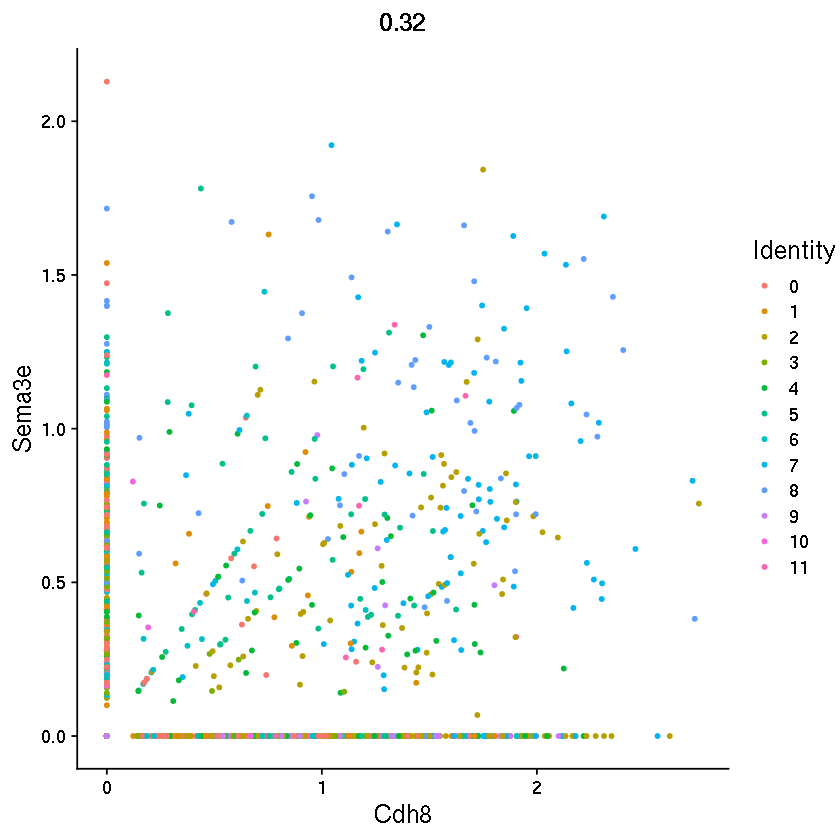

In [121]:
DefaultAssay(first.alpha.integrated) <- 'RNA'
FeatureScatter(first.alpha.integrated, feature1 = 'Cdh8', feature2 = 'Sema3e')


## Splitting alpha motor neurons by Chodl and Sv2a expression:

In [62]:
DefaultAssay(first.alpha.integrated) <- 'RNA'
chodl.pos <- WhichCells(object = first.alpha.integrated, expression = Chodl>0 & Sv2a==0)
sv2a.pos <- WhichCells(object = first.alpha.integrated, expression = Sv2a>0 & Chodl==0)



In [284]:
length(chodl.pos)

[1] 652

In [63]:
# chodl.barcodes <- unlist(strsplit(chodl.pos, split = '>'))[seq(1,length(chodl.pos),2)]
# sv2a.barcodes <- unlist(strsplit(sv2a.pos, split = '>'))[seq(1,length(sv2a.pos),2)]
ff.markers <- FindMarkers(first.alpha, ident.1=chodl.pos, ident.2=sv2a.pos)

In [64]:
ff.topten.markers <- rownames(ff.markers[order(ff.markers$pct.2-ff.markers$pct.1),])[1:10]
sf.topten.markers <- rownames(ff.markers[order(ff.markers$pct.1-ff.markers$pct.2),])[1:10]
alpha.expmat <- GetAssayData(first.alpha, assay='RNA')
ff.expmat <- alpha.expmat[c(ff.topten.markers),]

In [66]:
ff.topfifty.markers <- rownames(ff.markers[order(ff.markers$avg_logFC, decreasing = T),])[1:10]
sf.topfifty.markers <- rownames(ff.markers[order(ff.markers$avg_logFC),])[1:10]
ff.module <- list(ff.topfifty.markers)
sf.module <- list(sf.topfifty.markers)


Warning message in heatmap.2(as.matrix(ff.expmat), main = "Fast vs. Slow-Firing", :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”


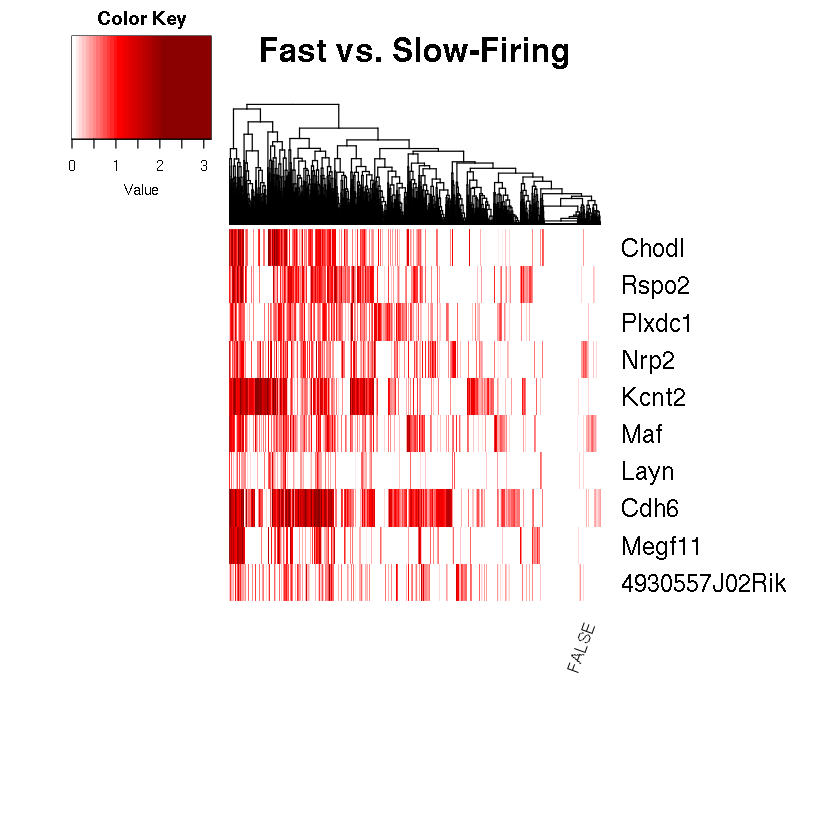

In [105]:
# pdf(file = paste(graph.dir, 'fast.v.slow.heatmap.pdf'), height = 8, width = 12)
heatmap.2(as.matrix(ff.expmat),
    main = "Fast vs. Slow-Firing", # heat map title
    notecol="black",      # change font color of cell labels to black
    density.info="none",  # turns off density plot inside color legend
    trace="none",         # turns off trace lines inside the heat map
#     margins =c(1,11),     # widens margins around plot
    dendrogram='both',     # only draw a row dendrogram
    Colv=T,
    Rowv=F,  
    key=T,
    labCol=F,
    col=colorRampPalette(c("white","red", "dark red", 'dark red'))(n = 40),
    symm=F,
    symbreaks=F,
    cexCol=0,
    cexRow=1.35,
    srtCol=70,
    margins=c(12,12))
# dev.off()

In [67]:
first.alpha.integrated <- AddModuleScore(
  object = first.alpha.integrated,
  features = list(ff.module),
  ctrl = 5,
  name = 'FF_Module'
)
first.alpha.integrated <- AddModuleScore(
  object = first.alpha.integrated,
  features = list(sf.module),
  ctrl = 5,
  name = 'SF_Module'
)

Warning message:
“The following features are not present in the object: c("Gm28928", "Cdh6", "Mctp1", "Pex5l", "Pitpnc1", "Rgs6", "Plxdc2", "L3mbtl4", "Dgkg", "Cpne4"), not searching for symbol synonyms”
Warning message in AddModuleScore(object = first.alpha.integrated, features = list(ff.module), :
“Could not find enough features in the object from the following feature lists:  Attempting to match case...”
Warning message in grep(pattern = paste0("^", s, "$"), x = match, ignore.case = TRUE, :
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message:
“The following features are not present in the object: c("Sgcd", "Opcml", "Pde1a", "Adcy8", "Htr1f", "Sdk2", "Fstl4", "Kirrel3", "Unc13c", "Mast4"), not searching for symbol synonyms”
Warning message in AddModuleScore(object = first.alpha.integrated, features = list(sf.module), :
“Could not find enough features in the object from the following feature lists:  Attempting to match case...”
Warning message i

In [71]:

fig_4j <- FeaturePlot(first.alpha.integrated, features = c('FF_Module1', 'SF_Module1'), blend = T, combine=F, cols=c('red', 'blue'))[[3]] + NoLegend() + NoAxes()
ggsave(filename = paste(graph.dir,'fig_4j.pdf'), plot= fig_4j, device = 'pdf')


Warning message:
“Only two colors provided, assuming specified are for features and agumenting with 'lightgrey' for double-negatives”
Saving 6.67 x 6.67 in image



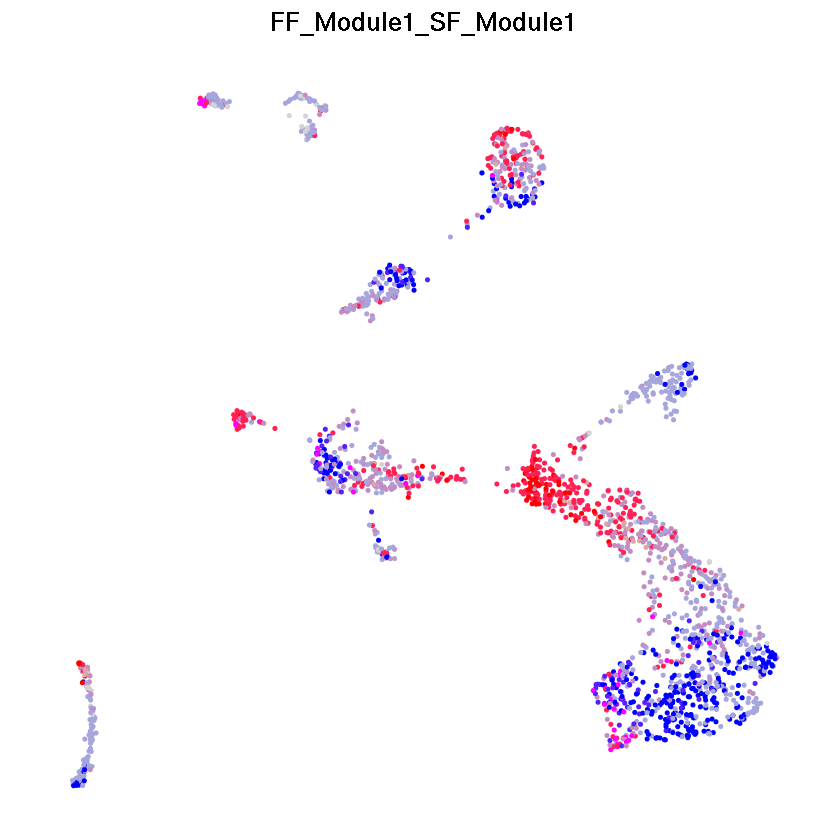

In [72]:
fig_4j

In [ ]:
Idents(first.inter) <- first.inter$seurat_clusters
first.inter <- reset.ids(first.inter,ident1.list=inter.list, ident2.label='inter_subtype', inter.cell.labels)
Idents(first.inter) <- first.inter$inter_subtype

In [ ]:
first.visceral <- reset.ids(first.visceral,ident1.list=visceral.list, ident2.label='visceral_subtype', visceral.cell.labels)
Idents(first.visceral) <- first.visceral$visceral_subtype

In [134]:
library(scales)
fig2_color_palette <- hue_pal()(length(skeletal.list) + length(visceral.list) + length(inter.list))

fig_2f <- DimPlot(first.skeletal, label=TRUE, repel=TRUE) + scale_color_manual(values = fig2_color_palette[c(3,6,9)])
fig_2g <- DimPlot(first.inter, label=TRUE, repel=TRUE) + scale_color_manual(values = fig2_color_palette[c(2,5,8)])
fig_2h <- DimPlot(first.visceral, label=TRUE, repel=TRUE) + scale_color_manual(values = fig2_color_palette[c(1,4,7,10)])

ggsave(filename = paste(graph.dir,'fig_2f.pdf'), plot= fig_2f, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2g.pdf'), plot= fig_2g, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2h.pdf'), plot= fig_2h, device = 'pdf')

ggsave(filename = paste(graph.dir,'fig_2f_nolegend.pdf'), plot= fig_2f+NoLegend(), device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2g_nolegend.pdf'), plot= fig_2g+NoLegend(), device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2h_nolegend.pdf'), plot= fig_2h+NoLegend(), device = 'pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [92]:
ggsave(filename = paste(graph.dir,'fig_2i.pdf'), plot= fig_2i, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2j.pdf'), plot= fig_2j, device = 'pdf')
ggsave(filename = paste(graph.dir,'fig_2k.pdf'), plot= fig_2k, device = 'pdf')

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



### *Skeletal motor neuron analysis*

In [154]:
fig_3a <- DimPlot(first.alpha, label=TRUE)+NoLegend()
ggsave(plot=fig_3a, filename = paste(graph.dir, 'fig_3a.pdf'), device='pdf')

fig_3b <- DimPlot(first.gamma, label=TRUE)+NoLegend()
ggsave(plot=fig_3b, filename = paste(graph.dir, 'fig_3b.pdf'), device='pdf')



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[[1]]


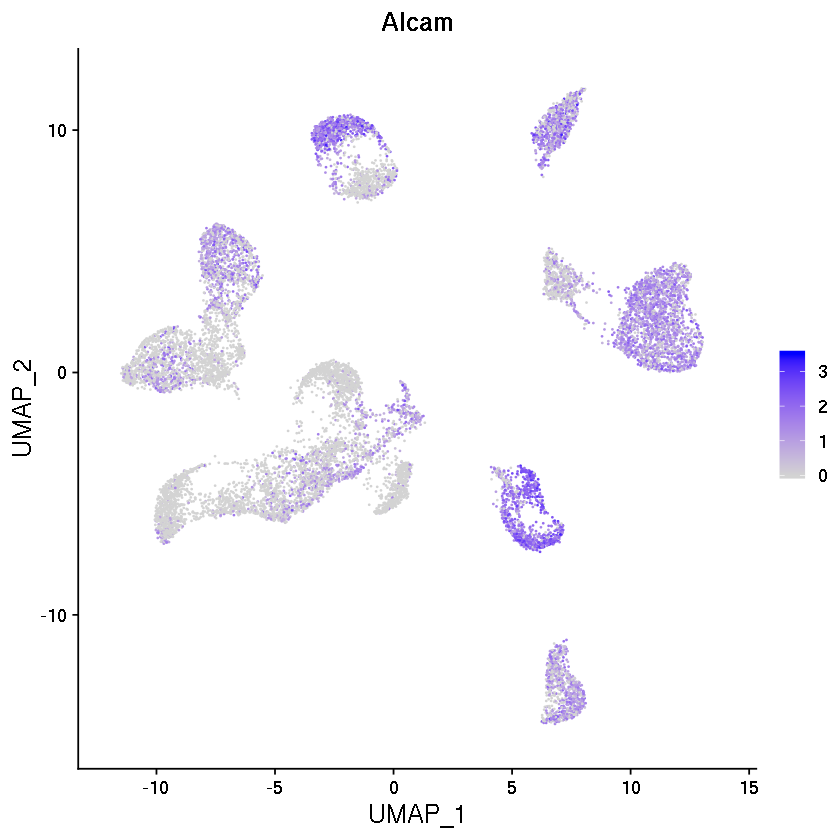

In [43]:
DefaultAssay(first.cholin) <- 'RNA'
FeaturePlot(first.cholin, features=c('Alcam'), combine = F)

[[1]]

[[2]]


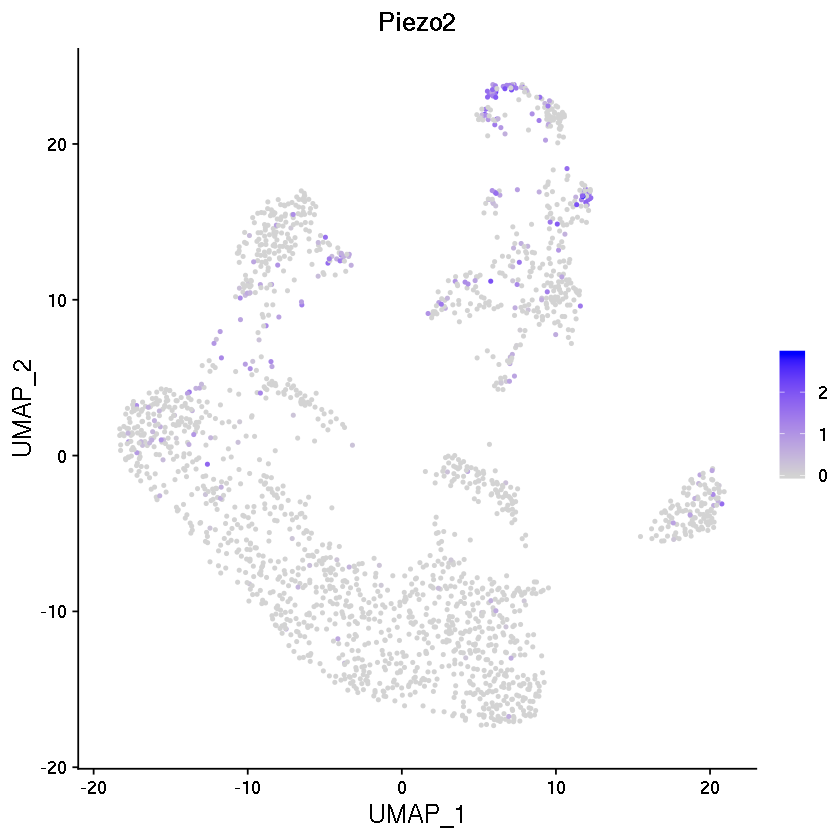

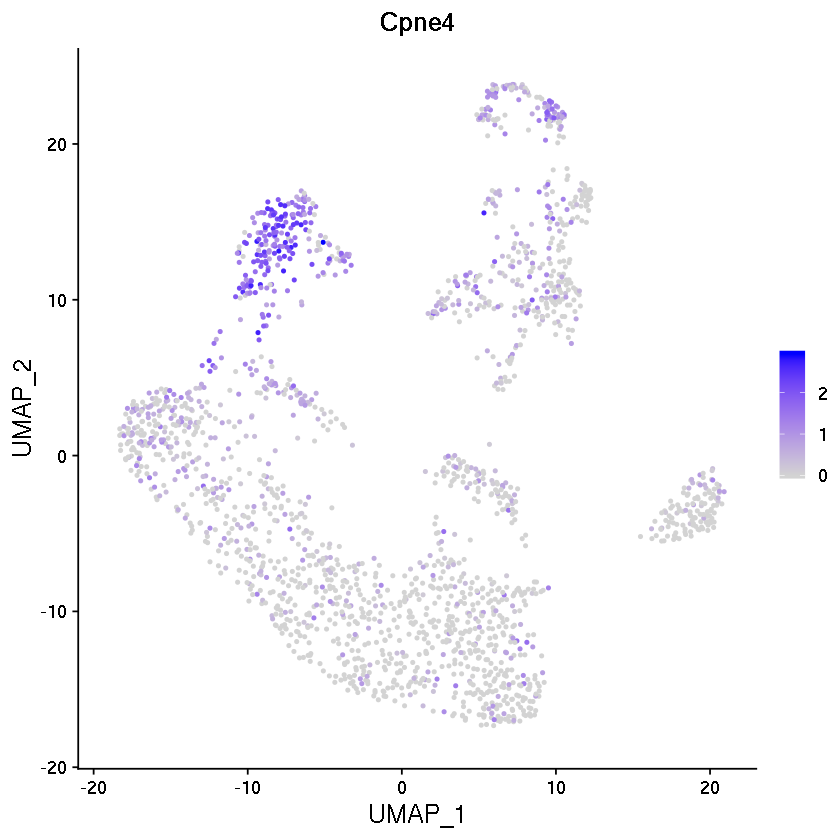

In [26]:
DefaultAssay(first.alpha) <- 'RNA'
FeaturePlot(first.alpha, features=c('Piezo2'), combine = F)

In [70]:
test <- data.frame(Loadings(first.alpha[['pca']]))

In [154]:
# alpha.celltype.markers <- FindAllMarkers(first.alpha, logfc.threshold = 0.5, max.cells.per.ident = 50, only.pos=TRUE)
gamma.celltype.markers <- FindAllMarkers(first.gamma, logfc.threshold = 0.5, max.cells.per.ident = 100, only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [155]:
write.csv(file=paste(graph.dir,'gamma.celltype.markers.csv'), gamma.celltype.markers)

In [126]:
alpha.heatmap.markers <- data.frame()
for (cell_type in c(0:8)) {
    temp.celltype.markers <- alpha.celltype.markers[alpha.celltype.markers$cluster==cell_type,]
    alpha.heatmap.markers <- rbind(alpha.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:10,])
}
alpha.heatmap.markers <- na.omit(alpha.heatmap.markers)
alpha.names.heatmap <- alpha.heatmap.markers$gene

In [156]:
gamma.heatmap.markers <- data.frame()
for (cell_type in c(0:3)) {
    temp.celltype.markers <- gamma.celltype.markers[gamma.celltype.markers$cluster==cell_type,]
    gamma.heatmap.markers <- rbind(gamma.heatmap.markers,temp.celltype.markers[order(temp.celltype.markers$pct.2),][1:10,])
}
gamma.heatmap.markers <- na.omit(gamma.heatmap.markers)
gamma.names.heatmap <- gamma.heatmap.markers$gene

In [163]:
fig_3c <- DoHeatmap(object=first.alpha,features=alpha.names.heatmap, label = FALSE) + theme(axis.text.y = element_text(size = 5))
fig_3d <- DoHeatmap(object=first.gamma,features=gamma.names.heatmap, label = FALSE) + theme(axis.text.y = element_text(size = 5))

In [164]:
ggsave(plot=fig_3c, filename = paste(graph.dir, 'fig_3c.pdf'), device='pdf')

ggsave(plot=fig_3d, filename = paste(graph.dir, 'fig_3d.pdf'), device='pdf')


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [168]:
DefaultAssay(first.alpha) <- 'RNA'
fig_3g <- FeaturePlot(first.alpha, features='PC_1', combine=F)

In [169]:
ggsave(plot=fig_3g, filename = paste(graph.dir, 'fig_3g.pdf'), device='pdf')


Saving 6.67 x 6.67 in image



ERROR: Error in UseMethod("grid.draw"): no applicable method for 'grid.draw' applied to an object of class "list"
